In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv(r"C:\Users\marat\OneDrive\Desktop\project\global temperature.csv")
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
df.set_index('Date', inplace=True)
df = df[['Temperature']]

 # Resample to monthly data
df.tail()


Temperature
Date                   
2022-07-27       10.229
2022-07-28       10.221
2022-07-29       10.164
2022-07-30       10.167
2022-07-31       10.219

In [5]:
import pandas as pd


df = pd.read_csv(r"C:\Users\marat\OneDrive\Desktop\project\global temperature.csv")
# Keep only relevant columns
df1 = df[['Year', 'Month', 'Temperature']]

# Descriptive statistics for each year
yearly_stats = df1.groupby('Year')['Temperature'].describe()

# Descriptive statistics for each month across all years
monthly_stats = df1.groupby('Month')['Temperature'].describe()

# Grouping into specific 20-year periods
bins = list(range(df1['Year'].min(), df1['Year'].max() + 1, 20))
bin_labels = [f"{bins[i]}-{bins[i+1]-1}" for i in range(len(bins)-1)]
df1['Year Group'] = pd.cut(df1['Year'], bins=bins, labels=bin_labels, right=False)
grouped_20yr_stats = df1.groupby('Year Group')['Temperature'].describe()

# Splitting the dataset into two equal time periods
mid_year = df1['Year'].median()
df1['Half'] = df1['Year'].apply(lambda x: 'First Half' if x <= mid_year else 'Second Half')
half_stats = df1.groupby('Half')['Temperature'].describe()

# Overall statistics
overall_stats = df1['Temperature'].describe()

# Compute average temperature for each month of each year
monthly_avg_per_year = df1.groupby(['Year', 'Month'])['Temperature'].mean().unstack()

# Compute average temperature for each year
yearly_avg_temp = df1.groupby('Year')['Temperature'].mean()

# Save results to an Excel workbook
with pd.ExcelWriter("temperature_analysis.xlsx") as writer:
    yearly_stats.to_excel(writer, sheet_name="Yearly Statistics")
    monthly_stats.to_excel(writer, sheet_name="Monthly Statistics")
    grouped_20yr_stats.to_excel(writer, sheet_name="20-Year Groups")
    half_stats.to_excel(writer, sheet_name="Two Halves")
    overall_stats.to_excel(writer, sheet_name="Overall Statistics")
    monthly_avg_per_year.to_excel(writer, sheet_name="Monthly Avg Per Year")
    yearly_avg_temp.to_excel(writer, sheet_name="Yearly Avg Temp")

# Display results
print("Descriptive Statistics by Year:\n", yearly_stats.head())
print("\nDescriptive Statistics by Month:\n", monthly_stats)
print("\nDescriptive Statistics by 20-Year Groups:\n", grouped_20yr_stats)
print("\nDescriptive Statistics for Two Equal Halves:\n", half_stats)
print("\nOverall Statistics:\n", overall_stats)
print("\nMonthly Average Temperature per Year (First 5 Years):\n", monthly_avg_per_year.head())
print("\nYearly Average Temperature (First 5 Years):\n", yearly_avg_temp.head())


Descriptive Statistics by Year:
       count      mean       std    min      25%     50%      75%    max
Year                                                                   
1880  366.0  7.995557  0.370984  6.945  7.76175  8.0630  8.29675  8.666
1881  365.0  8.255378  0.318727  7.213  8.01300  8.3050  8.48600  9.006
1882  365.0  8.116529  0.470746  6.720  7.86500  8.1440  8.36200  9.325
1883  365.0  7.995145  0.378379  6.852  7.88000  8.0710  8.24600  8.735
1884  366.0  7.801880  0.314403  7.001  7.57600  7.8285  7.99350  8.786

Descriptive Statistics by Month:
         count      mean       std    min      25%    50%      75%     max
Month                                                                    
1      4433.0  8.606167  0.836344  5.862  8.00400  8.578  9.17500  11.055
2      4039.0  8.622804  0.842865  6.117  8.00800  8.539  9.18250  11.545
3      4433.0  8.738859  0.826366  6.821  8.13500  8.625  9.26800  11.491
4      4290.0  8.902750  0.690573  7.156  8.40825  8.817  

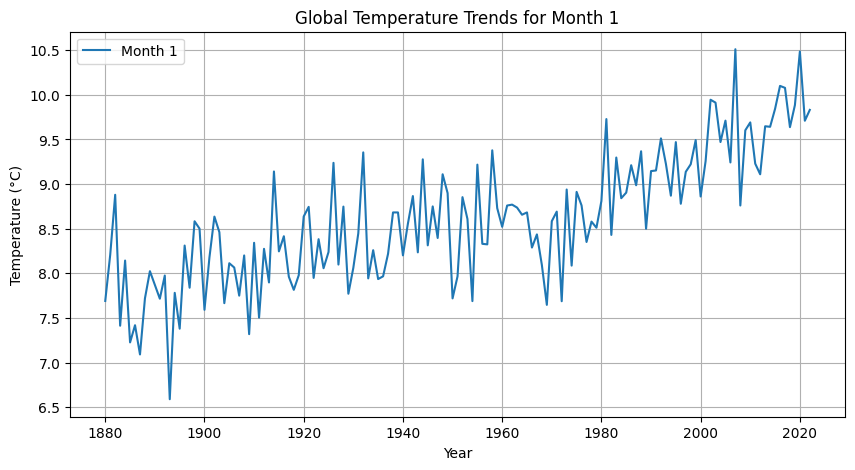

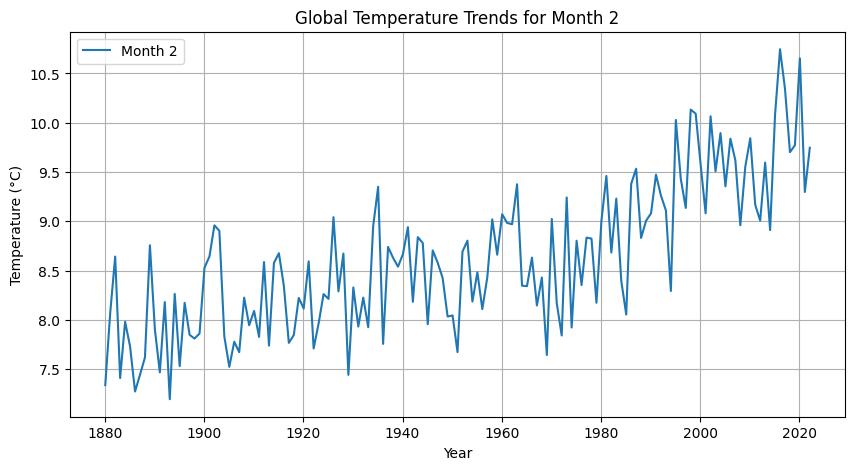

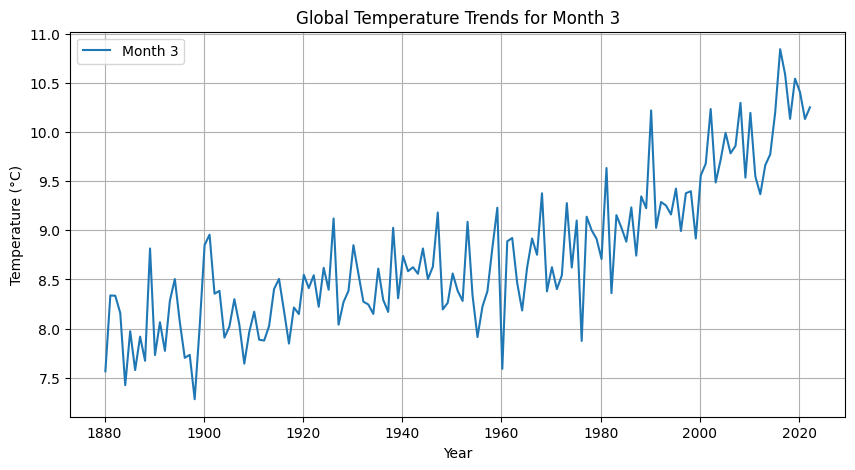

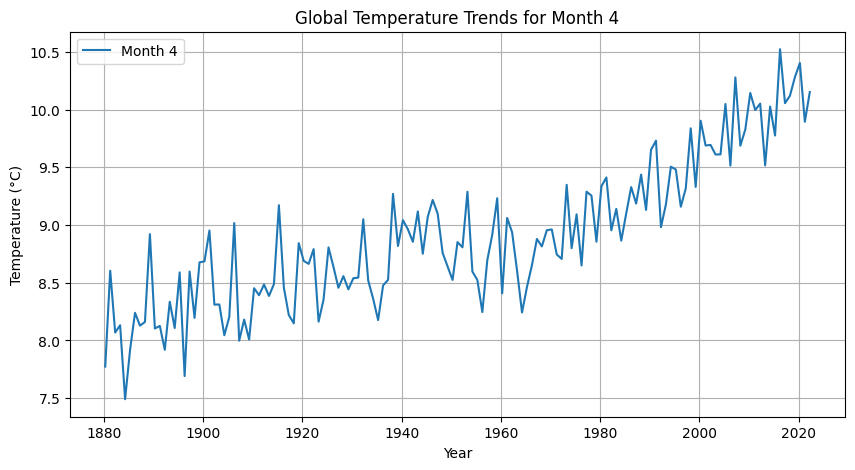

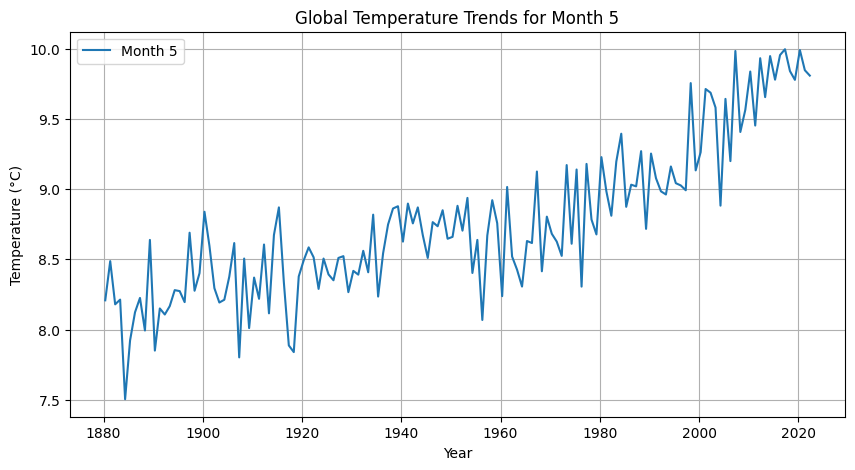

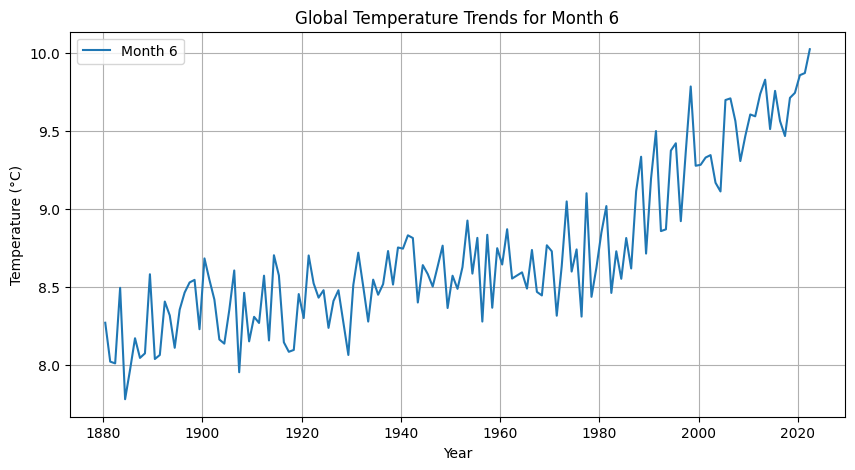

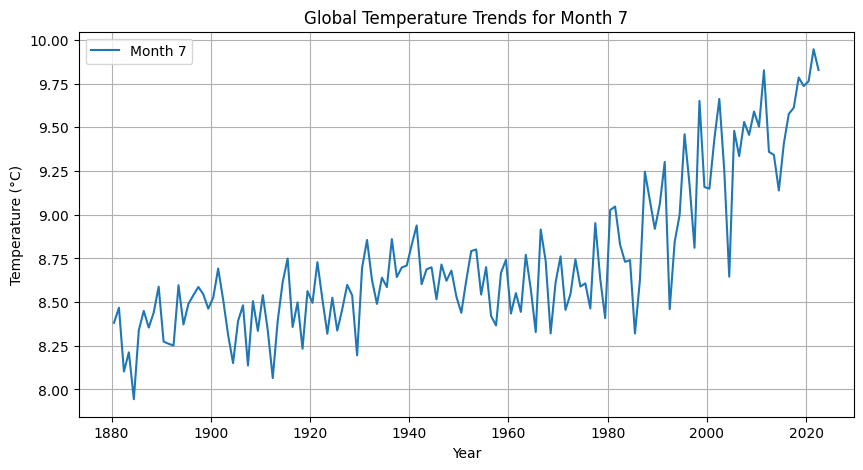

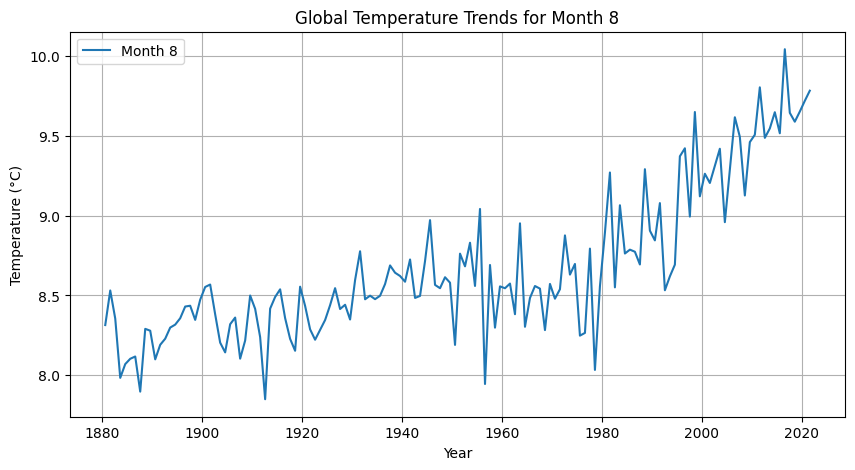

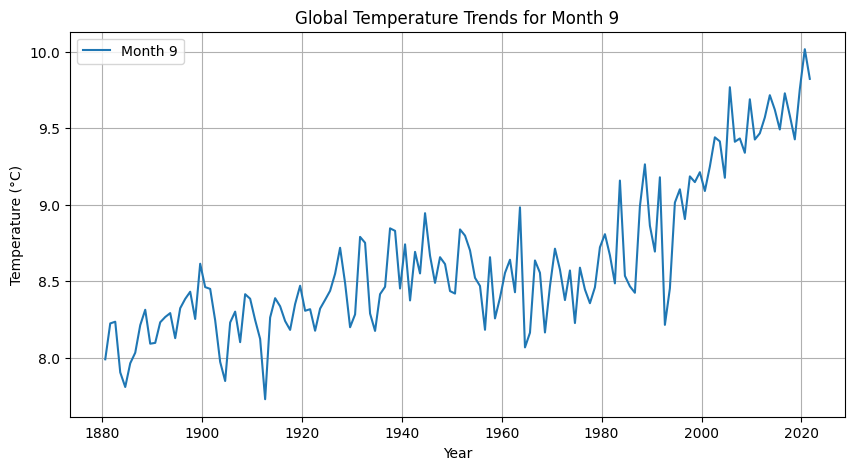

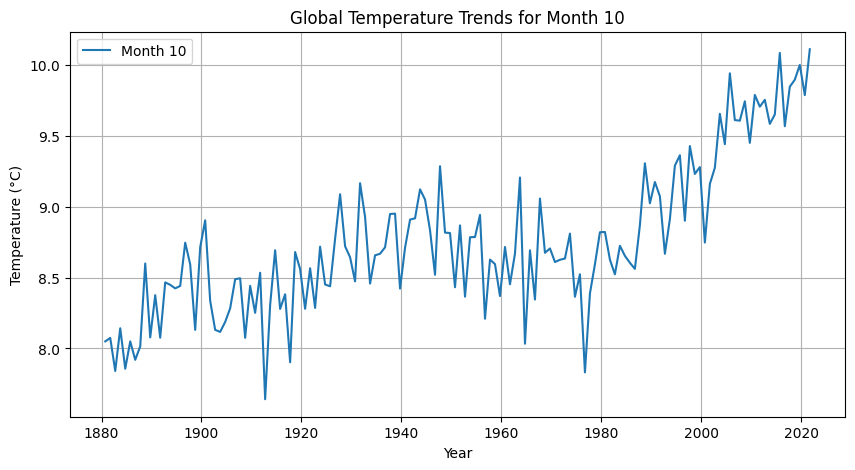

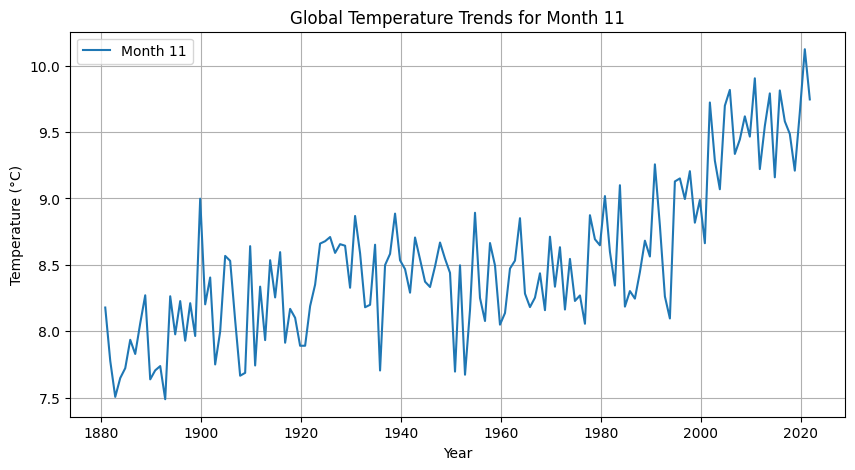

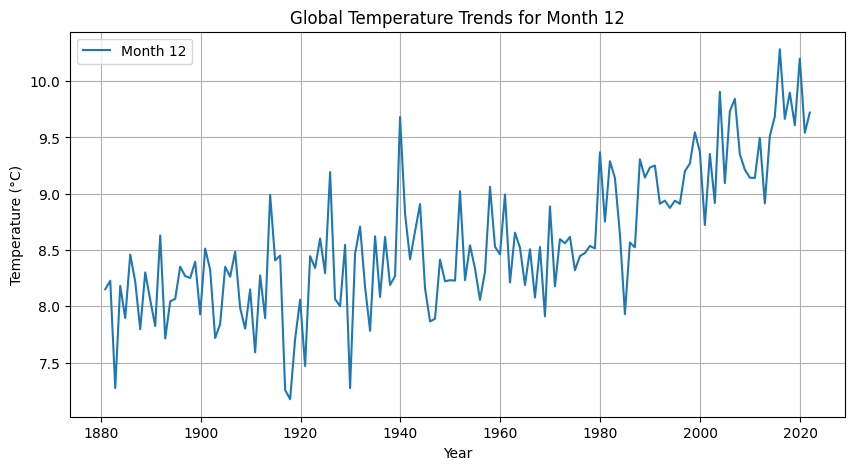

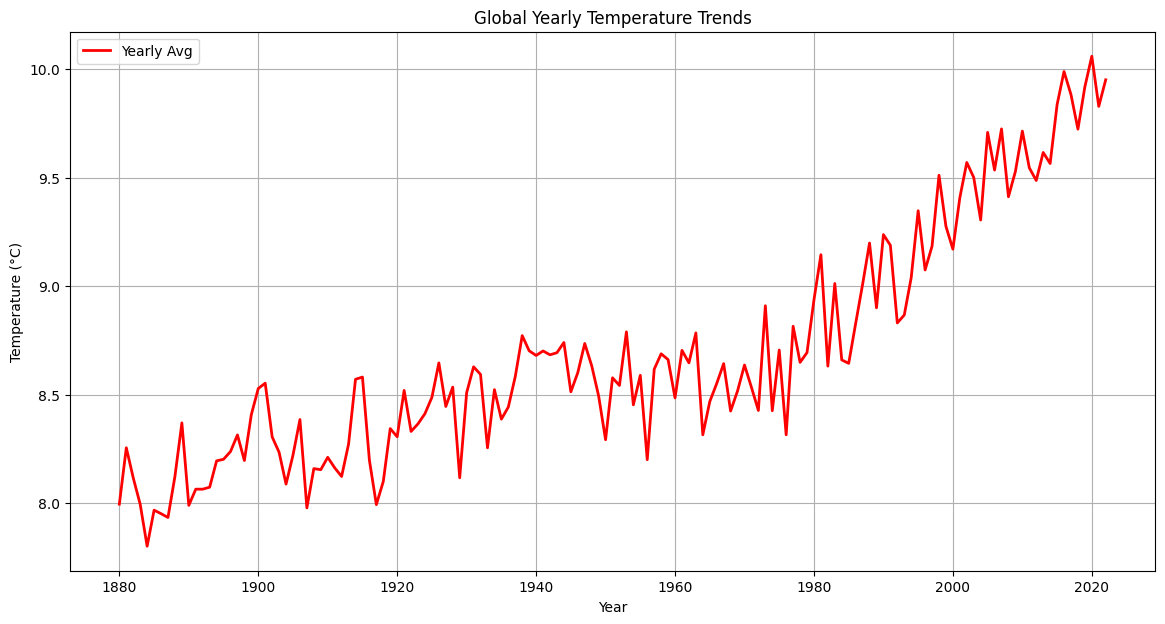

In [6]:
# Compute monthly and yearly averages
monthly_avg = df1.groupby(['Year', 'Month'])['Temperature'].mean().reset_index()
yearly_avg = df1.groupby('Year')['Temperature'].mean().reset_index()

# Convert to datetime format
monthly_avg['Date'] = pd.to_datetime(monthly_avg[['Year', 'Month']].assign(Day=1))
yearly_avg['Date'] = pd.to_datetime(yearly_avg['Year'], format='%Y')

# Plot separate time series for each month
for month in range(1, 13):
    plt.figure(figsize=(10, 5))
    month_data = monthly_avg[monthly_avg['Month'] == month]
    plt.plot(month_data['Date'], month_data['Temperature'], label=f"Month {month}")
    plt.xlabel("Year")
    plt.ylabel("Temperature (°C)")
    plt.title(f"Global Temperature Trends for Month {month}")
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot yearly averages separately
plt.figure(figsize=(14, 7))
plt.plot(yearly_avg['Date'], yearly_avg['Temperature'], label="Yearly Avg", linewidth=2, color='red')
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.title("Global Yearly Temperature Trends")
plt.legend()
plt.grid(True)
plt.show()

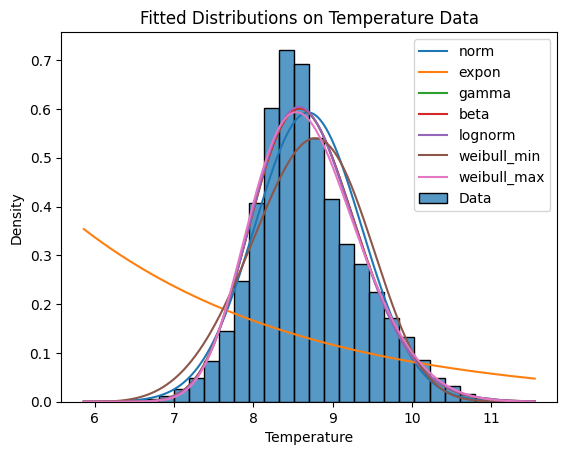


Kolmogorov-Smirnov Test Results:
             KS Statistic        P-Value
norm             0.059938  4.460529e-163
expon            0.427401   0.000000e+00
gamma            0.039049   1.968802e-69
beta             0.039012   2.664434e-69
lognorm          0.037038   1.654976e-62
weibull_min      0.074443  1.982387e-251
weibull_max      0.036362   2.928558e-60

Best Fit Distribution Parameters:
norm: (8.688502563511724, 0.6730782024854579)
expon: (5.862, 2.826502563511724)
gamma: (39.011663603959136, 4.497700761300052, 0.10742432871731672)
beta: (38.91710791425221, 36462635.28996915, 4.502371855935138, 3922091.870442043)
lognorm: (0.11628643083088369, 2.9328391979333386, 5.716837978733398)
weibull_min: (4.415801985131122, 5.859482916670485, 3.093586658959958)
weibull_max: (5.760986512463964, 12.050427154466213, 3.6289129305249883)


In [8]:
from scipy.stats import kstest, probplot
from scipy import stats

dist_names = ['norm', 'expon', 'gamma', 'beta', 'lognorm', 'weibull_min', 'weibull_max']
temperature_data = df1['Temperature'].dropna()

best_fit = {}
kstest_results = {}

def evaluate_fit(data, dist_name, params):
    dist = getattr(stats, dist_name)
    ks_stat, ks_pval = kstest(data, dist_name, args=params)
    return ks_stat, ks_pval

for dist_name in dist_names:
    dist = getattr(stats, dist_name)
    params = dist.fit(temperature_data)
    best_fit[dist_name] = params
    ks_stat, ks_pval = evaluate_fit(temperature_data, dist_name, params)
    kstest_results[dist_name] = {'KS Statistic': ks_stat, 'P-Value': ks_pval}

# Convert results to a DataFrame
kstest_df = pd.DataFrame.from_dict(kstest_results, orient='index')

# Plot histogram with fitted distributions
sns.histplot(temperature_data, kde=False, bins=30, stat="density", label="Data")

x = np.linspace(temperature_data.min(), temperature_data.max(), 1000)

for dist_name, params in best_fit.items():
    dist = getattr(stats, dist_name)
    pdf_fitted = dist.pdf(x, *params)
    plt.plot(x, pdf_fitted, label=dist_name)

plt.legend()
plt.xlabel("Temperature")
plt.ylabel("Density")
plt.title("Fitted Distributions on Temperature Data")
plt.show()




# Print KS Test results
print("\nKolmogorov-Smirnov Test Results:")
print(kstest_df)

# Print best-fit parameters for each distribution
print("\nBest Fit Distribution Parameters:")
for dist_name, params in best_fit.items():
    print(f"{dist_name}: {params}")

In [9]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df["Temperature"])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")  # Should be < 0.05 for stationarity



ADF Statistic: -9.527270949192072
p-value: 2.9547597002386714e-16


In [11]:


from pmdarima import auto_arima

auto_model = auto_arima(df["Temperature"], seasonal=False, d=0, trace=True)
print(auto_model.order)  # Get optimal (p, 0, q)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-56198.767, Time=11.99 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=373282.728, Time=0.22 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.78 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=2.02 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-56201.561, Time=2.68 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=236613.526, Time=2.98 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-56188.860, Time=1.32 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-56431.909, Time=3.18 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=182549.615, Time=6.46 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=15.05 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=-56858.515, Time=4.26 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=140580.872, Time=8.59 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=-56428.054, Time=21.32 sec
 ARIMA(1,0,5)(0,0,0)[0]             : AIC=-57280.176, Time=5.92 sec
 ARIMA(0,0,5)(0,0,0)[0]

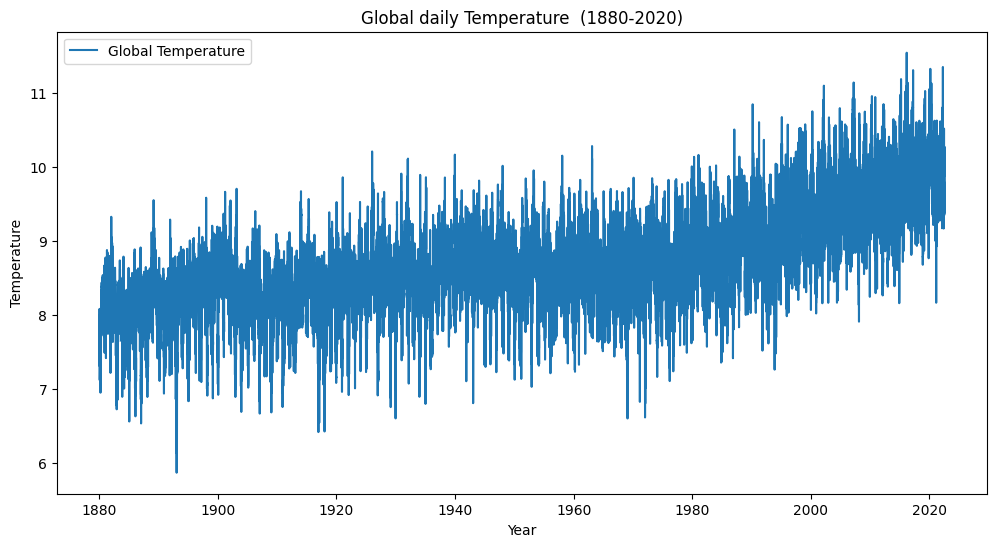

In [14]:
# Plot time series
plt.figure(figsize=(12,6))
plt.plot(df, label='Global Temperature')
plt.title('Global daily Temperature  (1880-2020)')
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.legend()
plt.show()




In [15]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv(r"C:\Users\marat\OneDrive\Desktop\project\global temperature.csv")
print(df.head())
# Keep only relevant columns
df = df[['Year', 'Month','Day of Year', 'Temperature']]

print(df.head())

# Descriptive statistics for each month across all years
monthly_stats = df.groupby('Month')['Temperature'].describe()

# Split into first 70 years (1880–1949) and second 70 years (1950–2020)
df_first = df[(df["Year"] >= 1880) & (df["Year"] < 1950)]
df_second = df[(df["Year"] >= 1950) & (df["Year"] <= 2020)]

# Group by year to get annual mean temperature
temp_first = df_first.groupby("Year")["Temperature"].mean().values
temp_second = df_second.groupby("Year")["Temperature"].mean().values

# **1. Hypothesis Testing: Two-sample t-test**
t_stat, p_value = stats.ttest_ind(temp_first, temp_second, equal_var=False)
print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")

if p_value < 0.05:
    print("Reject null hypothesis: There is a significant difference in means.")
else:
    print("Fail to reject null hypothesis: No significant difference in means.")




   Year  Month  Day  Day of Year  Anomaly  Temperature  Unnamed: 6  \
0  1880      1    1            1   -0.692        7.898         NaN   
1  1880      1    2            2   -0.592        7.998         NaN   
2  1880      1    3            3   -0.673        7.917         NaN   
3  1880      1    4            4   -0.615        7.975         NaN   
4  1880      1    5            5   -0.681        7.909         NaN   

   Unnamed: 7  Unnamed: 8 Unnamed: 9  
0         NaN         NaN        NaN  
1         NaN         NaN        NaN  
2         NaN         NaN        NaN  
3         NaN         NaN        NaN  
4         NaN         NaN        NaN  
   Year  Month  Day of Year  Temperature
0  1880      1            1        7.898
1  1880      1            2        7.998
2  1880      1            3        7.917
3  1880      1            4        7.975
4  1880      1            5        7.909
T-statistic: -10.3730, P-value: 0.0000
Reject null hypothesis: There is a significant difference in

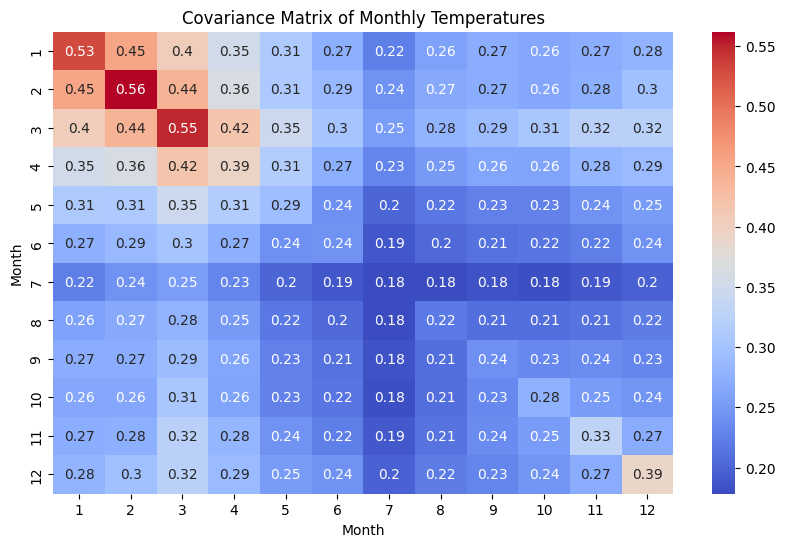

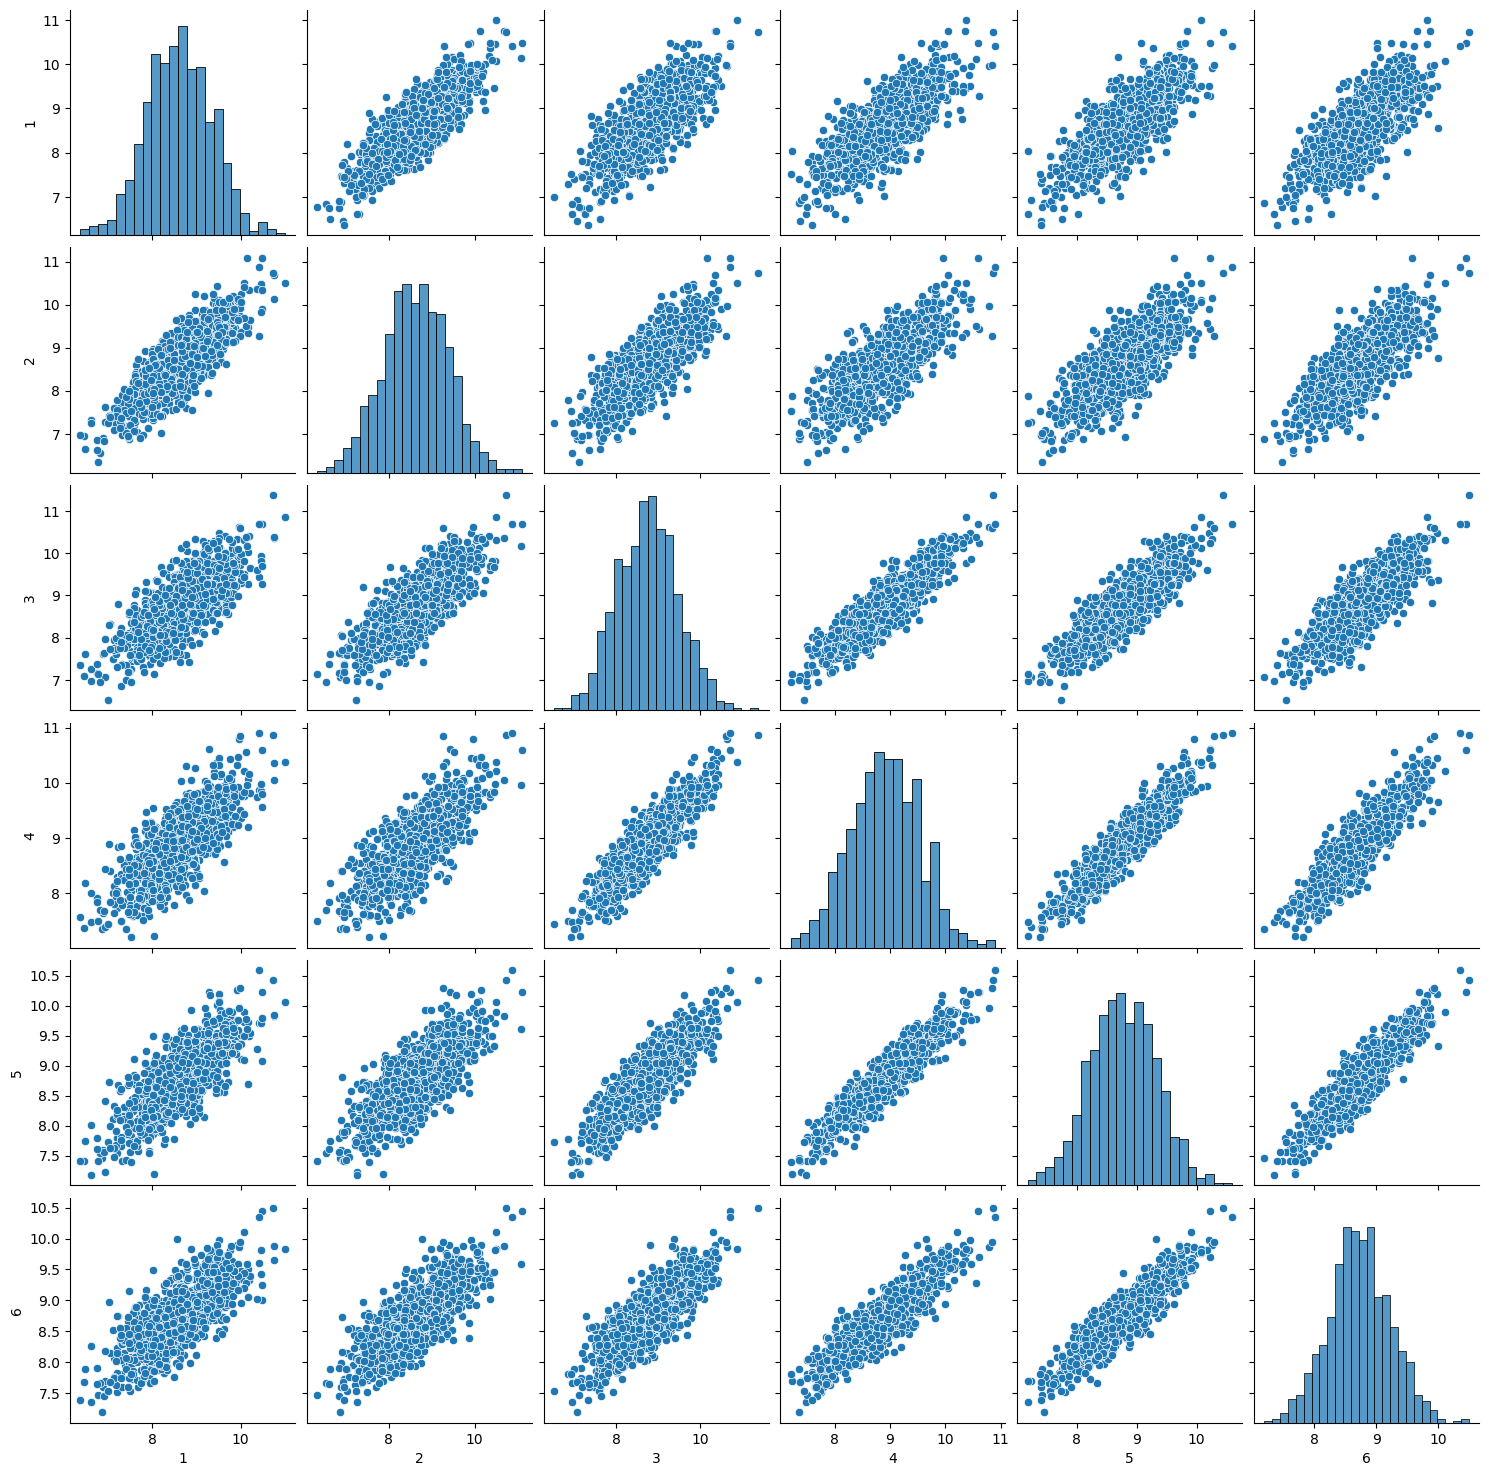

Normality Test Results (Shapiro-Wilk, p > 0.05 means normal): {'1': True, '2': False, '3': False, '4': False, '5': False, '6': False, '7': False, '8': False, '9': False, '10': False, '11': False, '12': False}


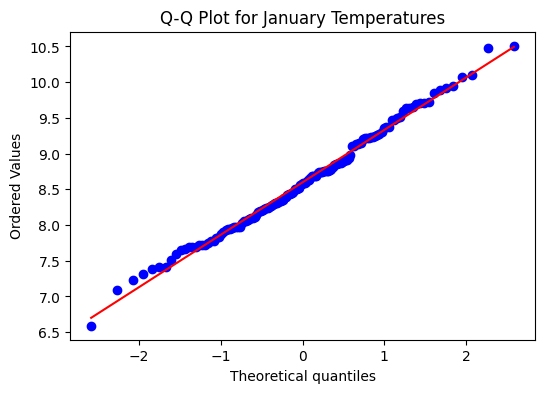

In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, shapiro, probplot

# Load dataset
file_path = "C:/Users/marat/OneDrive/Desktop/monthly avg temperature 140 years.csv"
df = pd.read_csv(file_path)

# Extract temperature data (excluding Year column)
temp_data = df.iloc[:, 1:]

# Compute mean vector and covariance matrix
mean_vector = temp_data.mean().values
cov_matrix = np.cov(temp_data, rowvar=False)

# Fit multivariate normal distribution
mvn = multivariate_normal(mean=mean_vector, cov=cov_matrix)

# Generate synthetic data
num_samples = 1000
synthetic_data = mvn.rvs(size=num_samples)
synthetic_df = pd.DataFrame(synthetic_data, columns=temp_data.columns)

# Plot covariance matrix
plt.figure(figsize=(10, 6))
sns.heatmap(cov_matrix, annot=True, cmap="coolwarm", xticklabels=range(1, 13), yticklabels=range(1, 13))
plt.title("Covariance Matrix of Monthly Temperatures")
plt.xlabel("Month")
plt.ylabel("Month")
plt.show()

# Pairwise scatter plot
sns.pairplot(synthetic_df.iloc[:, :6])  # Show first 6 months for clarity
plt.show()

# Normality test (Shapiro-Wilk)
norm_tests = {col: shapiro(temp_data[col]) for col in temp_data.columns}
norm_results = {col: (p > 0.05) for col, (stat, p) in norm_tests.items()}  # True means normality assumption holds
print("Normality Test Results (Shapiro-Wilk, p > 0.05 means normal):", norm_results)

# Q-Q plot for January
plt.figure(figsize=(6, 4))
probplot(temp_data.iloc[:, 0], dist="norm", plot=plt)
plt.title("Q-Q Plot for January Temperatures")
plt.show()


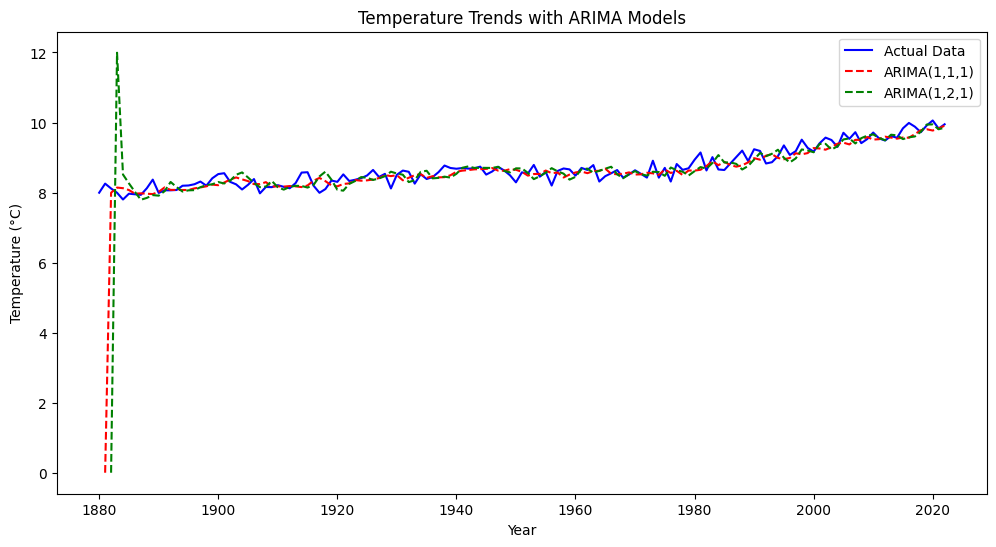

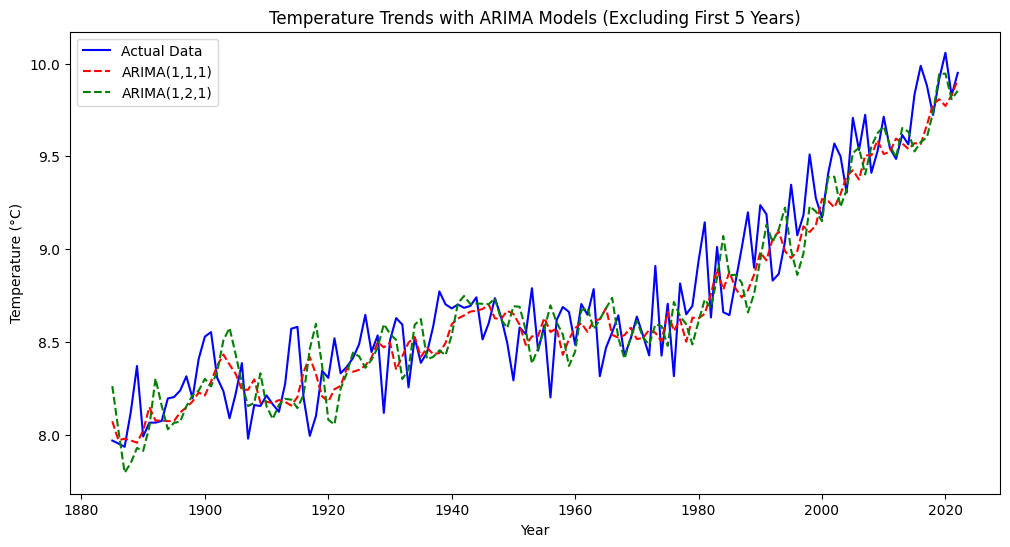

T-Statistic: -10.31, P-Value: 0.00000
Total Growth Rate: 24.44%
First 5 Groups of 10-Year Growth Rates: [-0.07022538931272218, 6.7358655350613486, -3.7144420289459217, 1.1520635541522117, 2.4429378605819605, 2.016799931543591, -4.471930981658008, 2.3227409494492166, 1.7858281021595983, 3.474973765674079, 3.3603618316609762, -0.7236654548554411, 5.928326627598929, 3.5507946184013943]
First 5 Groups of 20-Year Growth Rates: [6.660909857953048, -2.605171207649308, 4.509006961225421, -2.253061404350867, 5.322858925883758, 2.6123785990716573, 9.689623948854363]


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import ttest_ind

# Load the dataset (update file path if needed)
df = pd.read_csv(r"C:\Users\marat\OneDrive\Desktop\project\global temperature.csv")

# Aggregate data by year (assuming 'Year' and 'Temperature' columns exist)
df_yearly = df.groupby("Year")["Temperature"].mean().reset_index()

# Extract year and temperature series
years = df_yearly["Year"]
temperature = df_yearly["Temperature"]

# Fit ARIMA(1,1,1) model
model_111 = ARIMA(temperature, order=(1,1,1)).fit()

# Fit ARIMA(1,2,1) model
model_121 = ARIMA(temperature, order=(1,2,1)).fit()

# Shift fitted values to align properly
fitted_111 = model_111.fittedvalues.shift(1)
fitted_121 = model_121.fittedvalues.shift(2)

# Split into first 70 years and second 70 years
first_70 = temperature[:70]
second_70 = temperature[70:140]

# Hypothesis test (equality of means)
t_stat, p_value = ttest_ind(first_70, second_70, equal_var=False)

# Calculate total growth rate
total_growth_rate = (temperature.iloc[-1] - temperature.iloc[0]) / temperature.iloc[0] * 100

# Compute 10-year and 20-year grouped growth rates
growth_10_years = [
    (temperature.iloc[i+10] - temperature.iloc[i]) / temperature.iloc[i] * 100
    for i in range(0, len(temperature)-10, 10)
]
growth_20_years = [
    (temperature.iloc[i+20] - temperature.iloc[i]) / temperature.iloc[i] * 100
    for i in range(0, len(temperature)-20, 20)
]

# Plot actual data and ARIMA fits
plt.figure(figsize=(12, 6))
plt.plot(years, temperature, label="Actual Data", color="blue")
plt.plot(years, fitted_111, label="ARIMA(1,1,1)", linestyle="dashed", color="red")
plt.plot(years, fitted_121, label="ARIMA(1,2,1)", linestyle="dashed", color="green")
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.title("Temperature Trends with ARIMA Models")
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(years[5:], temperature[5:], label="Actual Data", color="blue")
plt.plot(years[5:], fitted_111[5:], label="ARIMA(1,1,1)", linestyle="dashed", color="red")
plt.plot(years[5:], fitted_121[5:], label="ARIMA(1,2,1)", linestyle="dashed", color="green")
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.title("Temperature Trends with ARIMA Models (Excluding First 5 Years)")
plt.show()
# Print results
print(f"T-Statistic: {t_stat:.2f}, P-Value: {p_value:.5f}")
print(f"Total Growth Rate: {total_growth_rate:.2f}%")
print(f"First 5 Groups of 10-Year Growth Rates: {growth_10_years}")
print(f"First 5 Groups of 20-Year Growth Rates: {growth_20_years}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step 


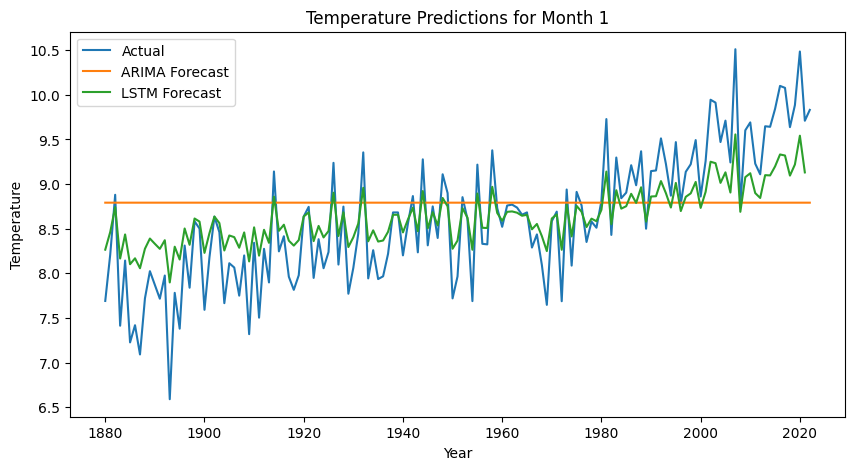

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step 


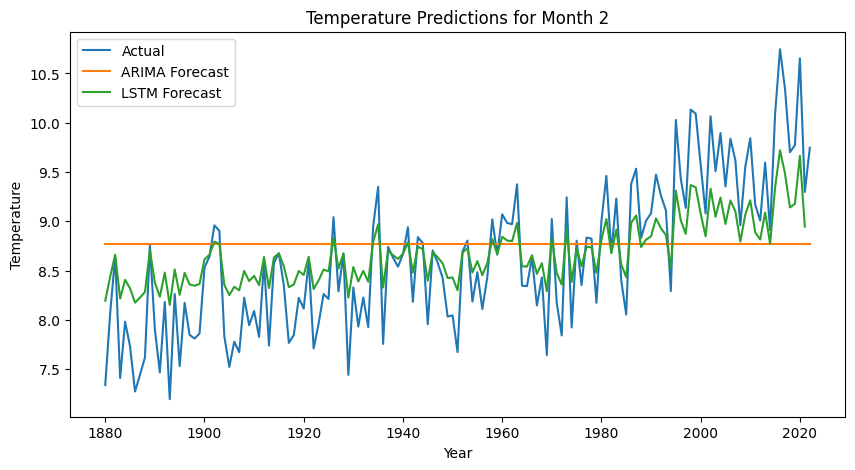

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step 


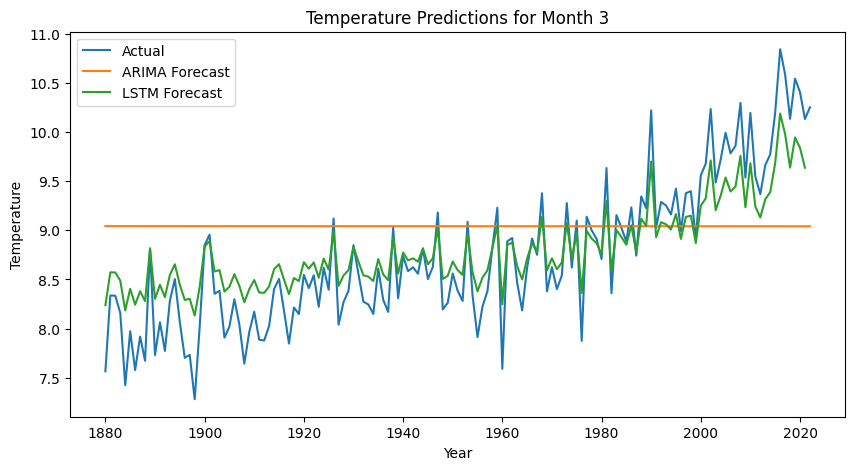

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step 


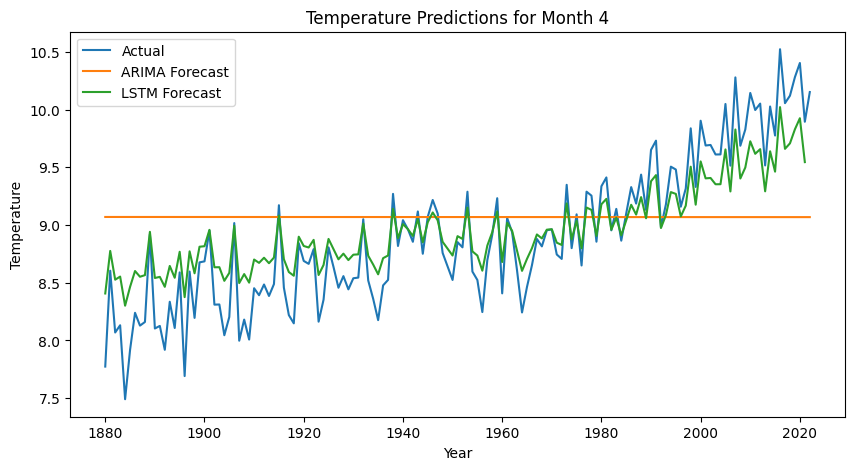

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step 


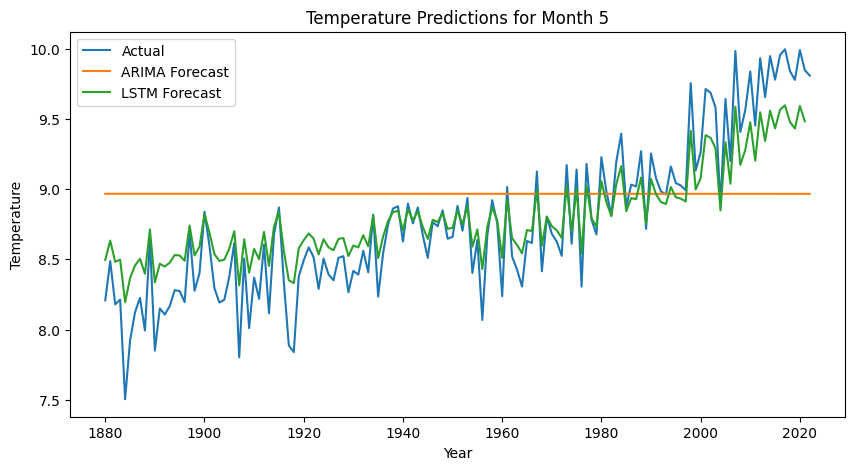

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step 


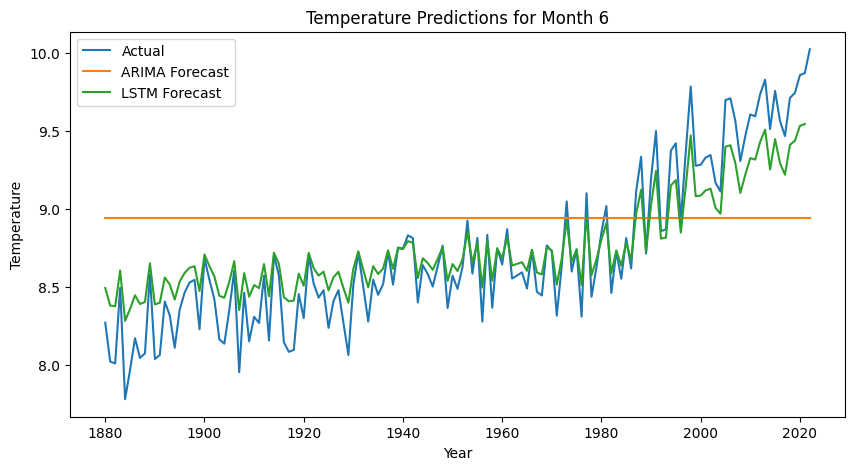

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step 


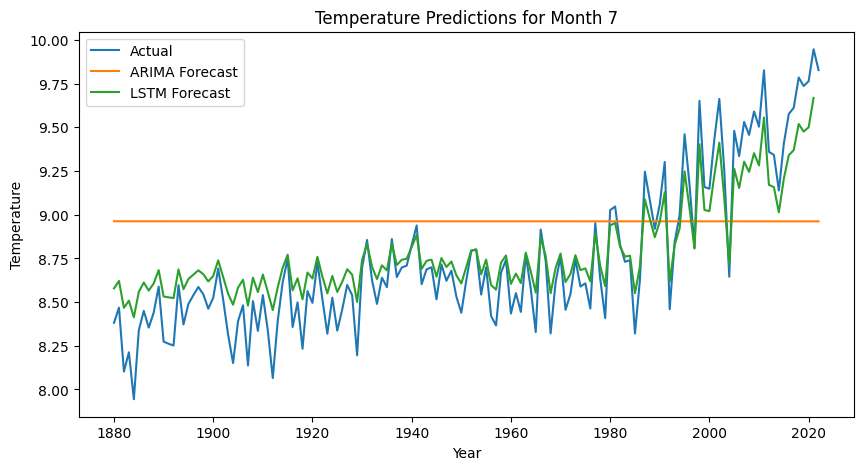

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step 


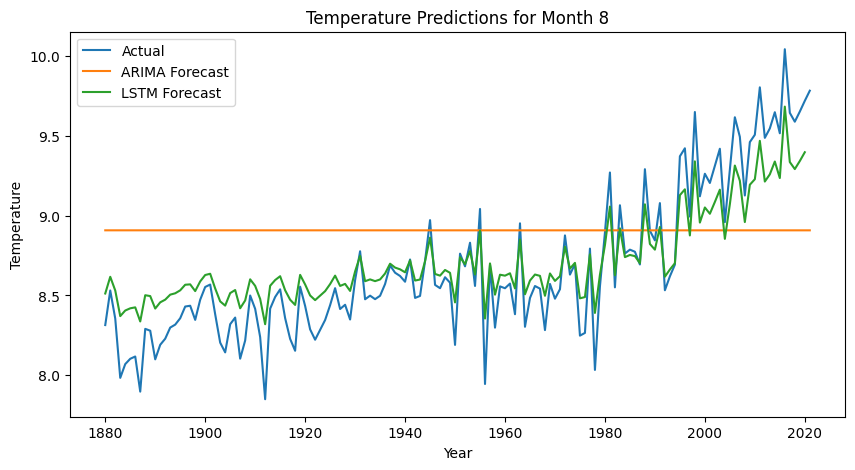

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step 


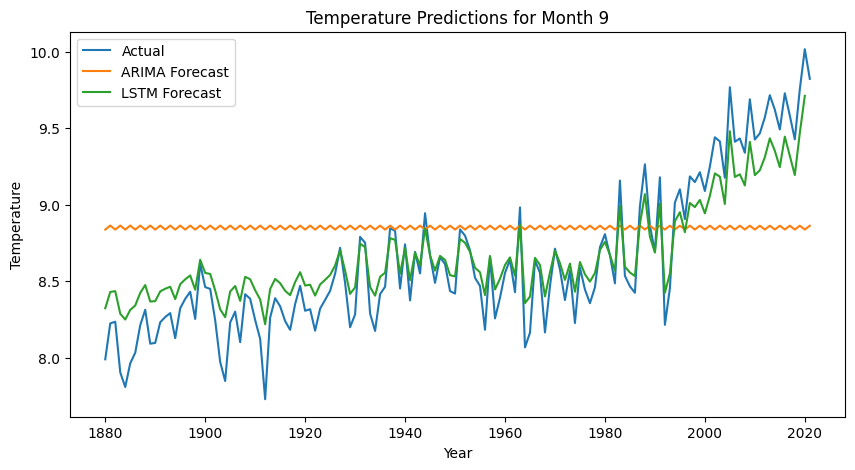

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step 


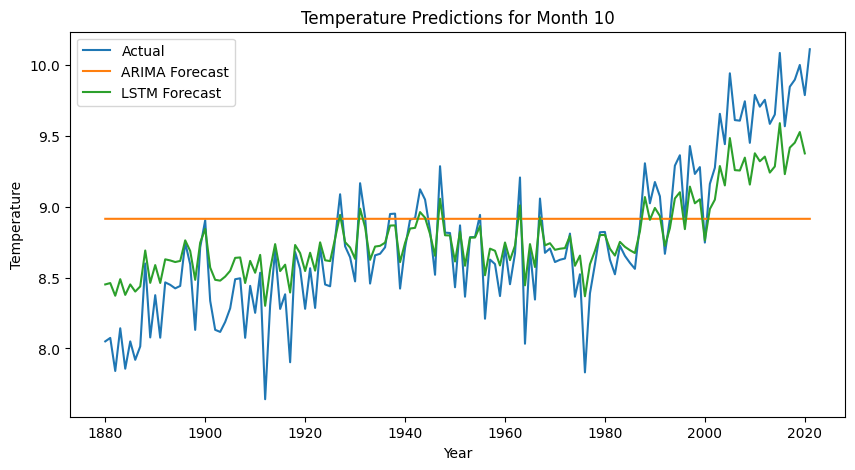

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step 


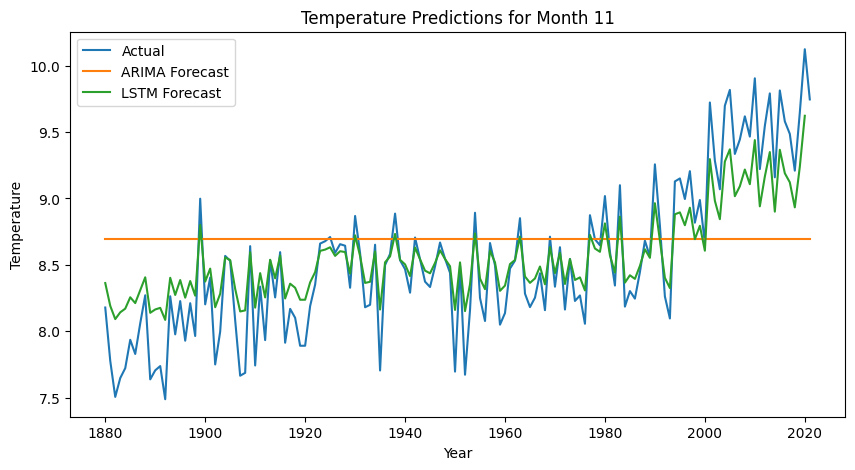

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step 


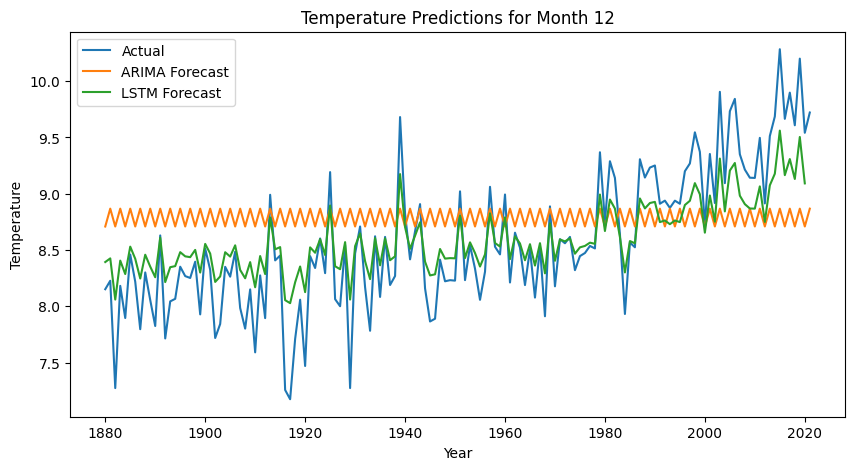

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step 


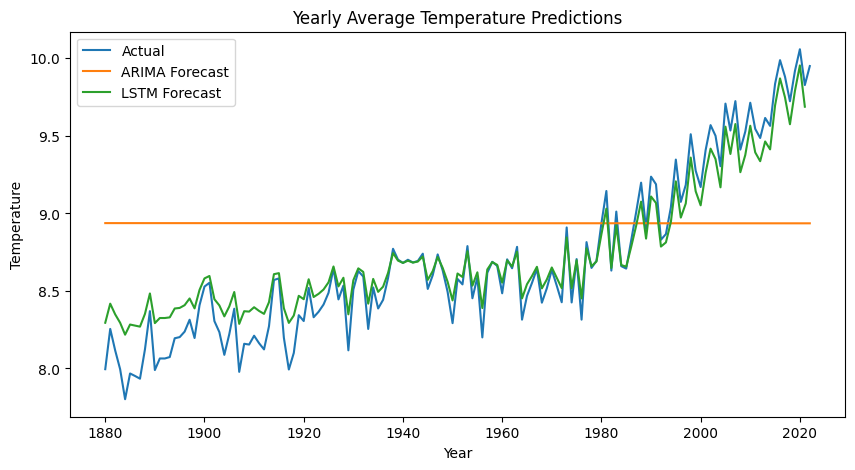

In [19]:
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

monthly_avg_per_year = df1.groupby(['Year', 'Month'])['Temperature'].mean().unstack()

# Compute average temperature for each year
yearly_avg_temp = df1.groupby('Year')['Temperature'].mean()

# Function to apply ARIMA model
def apply_arima(series):
    model = ARIMA(series, order=(2,0,2))
    model_fit = model.fit()
    forecast = model_fit.predict(start=series.index[0], end=series.index[-1])
    return forecast, model_fit.summary()

# Function to apply LSTM model
def apply_lstm(series):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(series.values.reshape(-1, 1))
    
    X, y = [], []
    for i in range(len(scaled_data) - 1):
        X.append(scaled_data[i])
        y.append(scaled_data[i + 1])
    
    X, y = np.array(X), np.array(y)
    X = X.reshape((X.shape[0], 1, X.shape[1]))
    
    model = Sequential([
        LSTM(50, activation='relu', return_sequences=True, input_shape=(1, 1)),
        LSTM(50, activation='relu'),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=50, verbose=0)
    
    predictions = model.predict(X).flatten()
    predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
    
    return model, predictions

# Apply ARIMA and LSTM for each month
arima_results = {}
lstm_models = {}
forecasted_arima = {}
forecasted_lstm = {}

for month in range(1, 13):
    series = monthly_avg_per_year[month].dropna()
    if len(series) > 10:  # Ensure sufficient data points
        forecasted_arima[month], arima_results[month] = apply_arima(series)
        lstm_models[month], forecasted_lstm[month] = apply_lstm(series)
        
        # Ensure same length for plotting
        forecasted_arima_series = pd.Series(forecasted_arima[month], index=series.index)
        forecasted_lstm_series = pd.Series(forecasted_lstm[month], index=series.index[:-1])
        
        # Plot actual vs predicted
        plt.figure(figsize=(10,5))
        plt.plot(series.index, series.values, label="Actual")
        plt.plot(series.index, forecasted_arima_series, label="ARIMA Forecast")
        plt.plot(series.index[:-1], forecasted_lstm_series, label="LSTM Forecast")
        plt.xlabel("Year")
        plt.ylabel("Temperature")
        plt.title(f"Temperature Predictions for Month {month}")
        plt.legend()
        plt.show()

# Apply ARIMA and LSTM for yearly average temperatures
forecasted_arima_yearly, arima_yearly = apply_arima(yearly_avg_temp)
lstm_yearly, forecasted_lstm_yearly = apply_lstm(yearly_avg_temp)

# Ensure same length for plotting
forecasted_arima_yearly_series = pd.Series(forecasted_arima_yearly, index=yearly_avg_temp.index)
forecasted_lstm_yearly_series = pd.Series(forecasted_lstm_yearly, index=yearly_avg_temp.index[:-1])

# Plot actual vs predicted for yearly averages
plt.figure(figsize=(10,5))
plt.plot(yearly_avg_temp.index, yearly_avg_temp.values, label="Actual")
plt.plot(yearly_avg_temp.index, forecasted_arima_yearly_series, label="ARIMA Forecast")
plt.plot(yearly_avg_temp.index[:-1], forecasted_lstm_yearly_series, label="LSTM Forecast")
plt.xlabel("Year")
plt.ylabel("Temperature")
plt.title("Yearly Average Temperature Predictions")
plt.legend()
plt.show()



In [22]:
# Function to evaluate models
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mae, rmse

# Function to fit ARIMA model
def fit_arima(train, test):
    model = ARIMA(train, order=(3,1,3))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(test))
    return forecast

# Function to fit LSTM model
def fit_lstm(train, test):
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train.values.reshape(-1,1))
    
    X_train, y_train = [], []
    for i in range(10, len(train_scaled)):
        X_train.append(train_scaled[i-10:i, 0])
        y_train.append(train_scaled[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(loss='mse', optimizer='adam')
    model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=0)
    
    test_scaled = scaler.transform(test.values.reshape(-1,1))
    X_test = np.array([test_scaled[i-10:i, 0] for i in range(10, len(test_scaled))])
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred_scaled)
    return y_pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
Period 1880-1900
ARIMA: MAE=0.6521, RMSE=0.7604
LSTM: MAE=0.1421, RMSE=0.1872



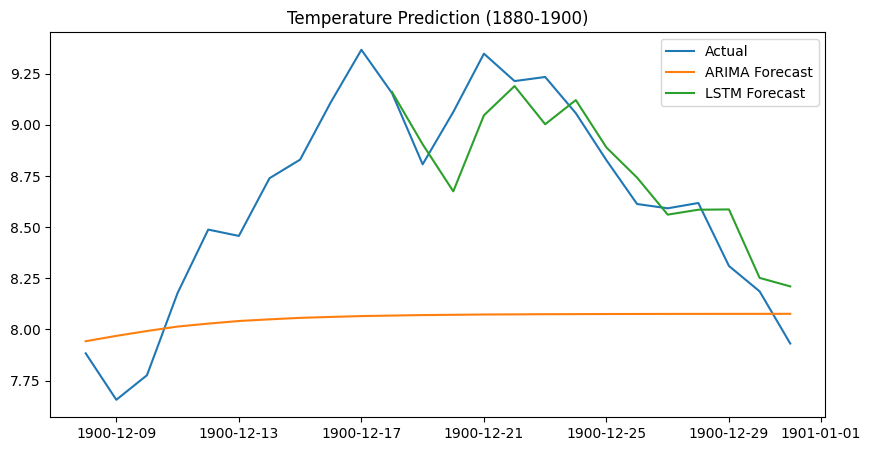

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
Period 1900-1920
ARIMA: MAE=0.2620, RMSE=0.3160
LSTM: MAE=0.1227, RMSE=0.1398



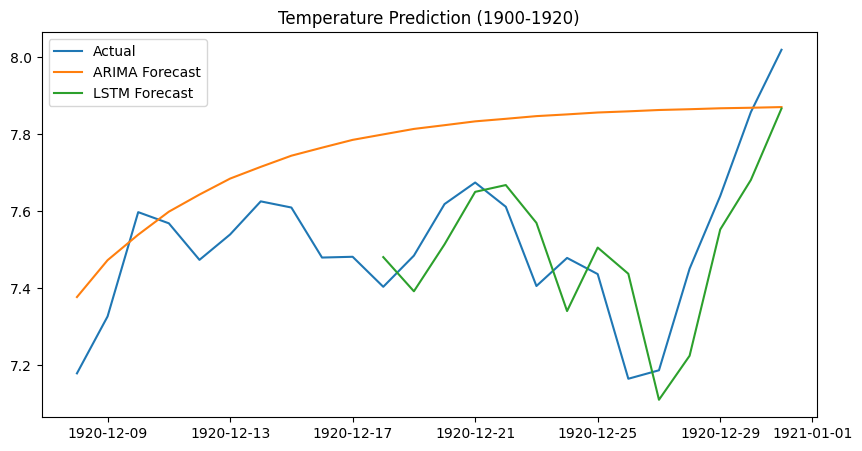

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
Period 1920-1940
ARIMA: MAE=0.3668, RMSE=0.4295
LSTM: MAE=0.1519, RMSE=0.1899



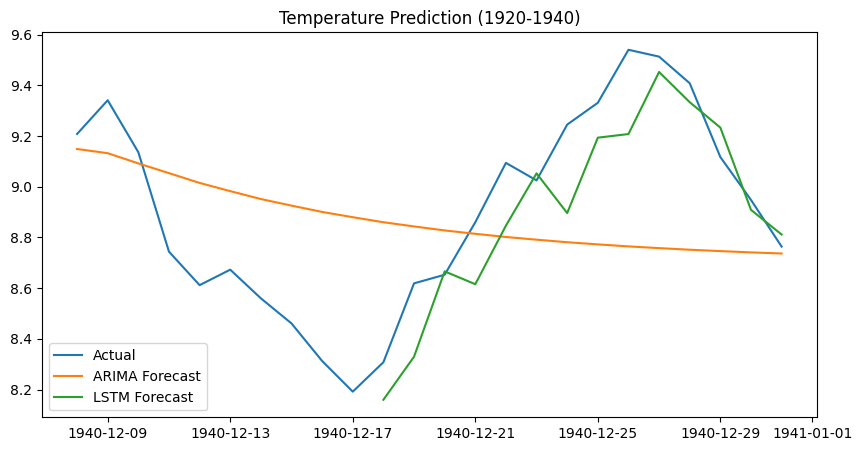

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
Period 1940-1960
ARIMA: MAE=0.2552, RMSE=0.2978
LSTM: MAE=0.1305, RMSE=0.1784



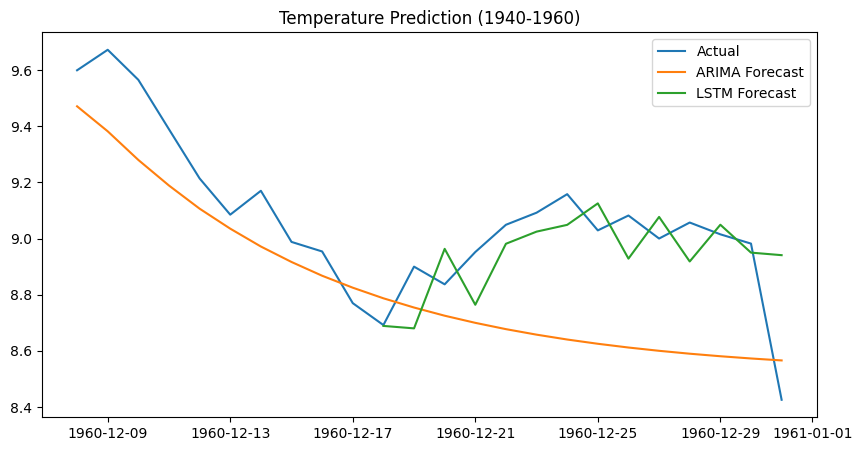

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
Period 1960-1980
ARIMA: MAE=0.3459, RMSE=0.4464
LSTM: MAE=0.1337, RMSE=0.1543



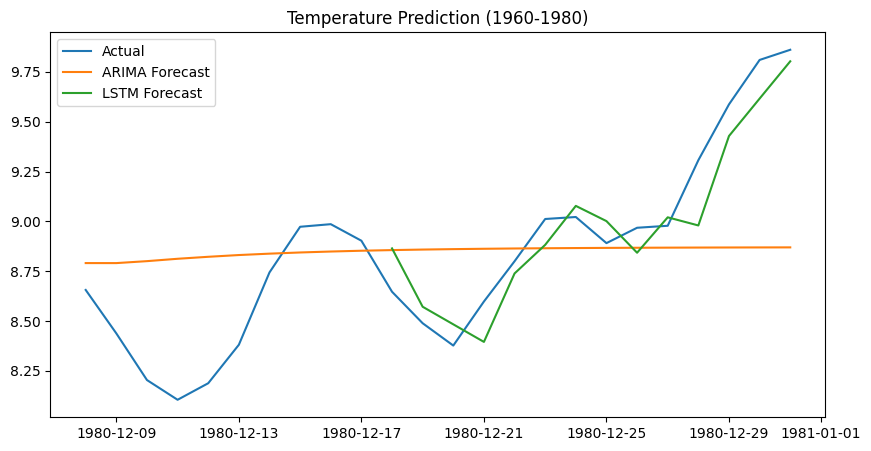

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
Period 1980-2000
ARIMA: MAE=0.2316, RMSE=0.2600
LSTM: MAE=0.0938, RMSE=0.1093



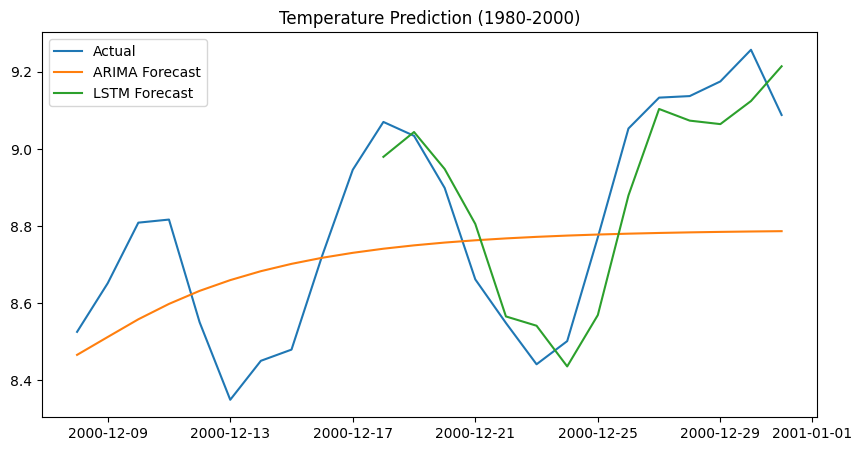

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
Period 2000-2020
ARIMA: MAE=0.6488, RMSE=0.6856
LSTM: MAE=0.0873, RMSE=0.1099



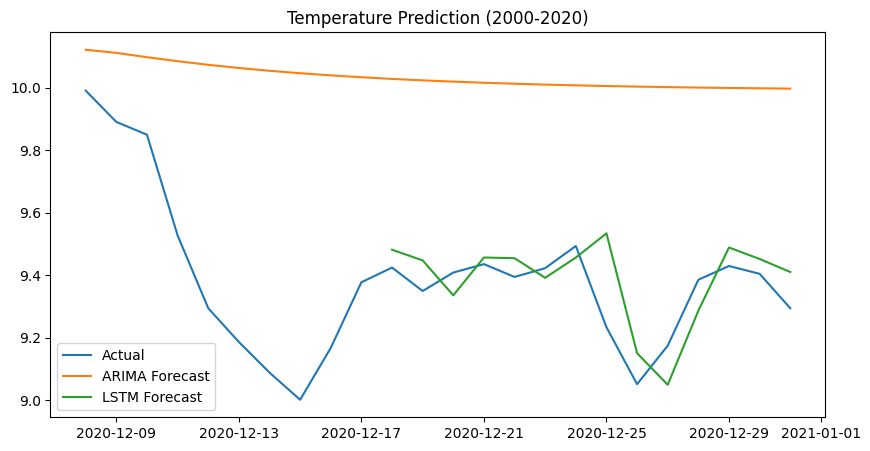

In [11]:
# Time-Split Modeling
for start in range(1880, 2001, 20):
    end = start + 20
    subset = df.loc[f'{start}':f'{end}']
    train, test = subset.iloc[:-24], subset.iloc[-24:]
    
    # ARIMA Model
    arima_forecast = fit_arima(train, test)
    
    # LSTM Model
    lstm_forecast = fit_lstm(train, test)
    
    # Evaluate Models
    arima_mae, arima_rmse = evaluate_model(test, arima_forecast)
    lstm_mae, lstm_rmse = evaluate_model(test[-len(lstm_forecast):], lstm_forecast)
    
    print(f'Period {start}-{end}')
    print(f'ARIMA: MAE={arima_mae:.4f}, RMSE={arima_rmse:.4f}')
    print(f'LSTM: MAE={lstm_mae:.4f}, RMSE={lstm_rmse:.4f}\n')
    
    # Plot Results
    plt.figure(figsize=(10, 5))
    plt.plot(test.index, test, label='Actual')
    plt.plot(test.index, arima_forecast, label='ARIMA Forecast')
    plt.plot(test.index[-len(lstm_forecast):], lstm_forecast, label='LSTM Forecast')
    plt.title(f'Temperature Prediction ({start}-{end})')
    plt.legend()
    plt.show()

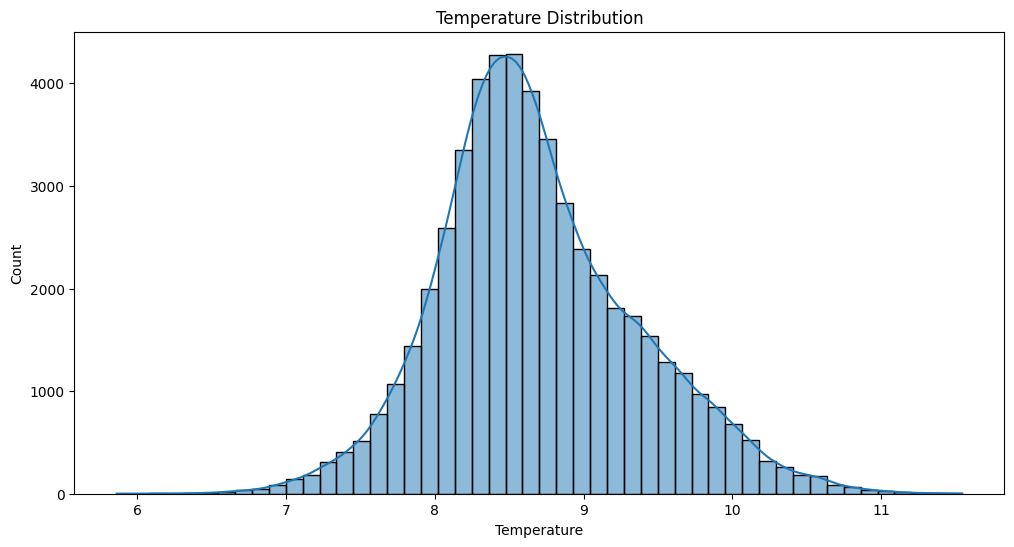

Shapiro-Wilk Test: Statistic=0.9765, p-value=0.0000
D’Agostino and Pearson Test: Statistic=1555.4371, p-value=0.0000
Anderson-Darling Test:
  15.0%: 0.5760
  10.0%: 0.6560
  5.0%: 0.7870
  2.5%: 0.9180
  1.0%: 1.0920


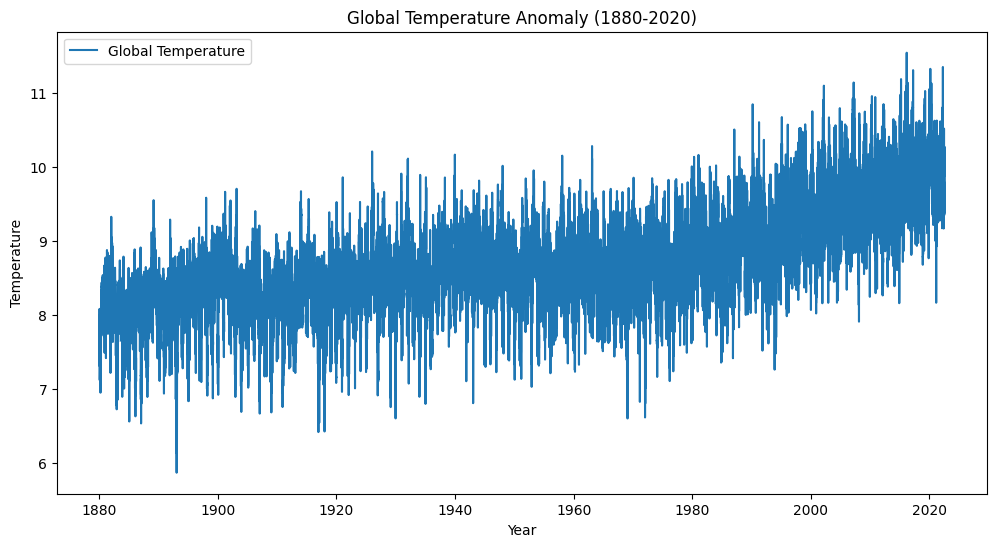

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
Period 1880-1900
ARIMA: MAE=0.6521, RMSE=0.7604
LSTM: MAE=0.1801, RMSE=0.2037



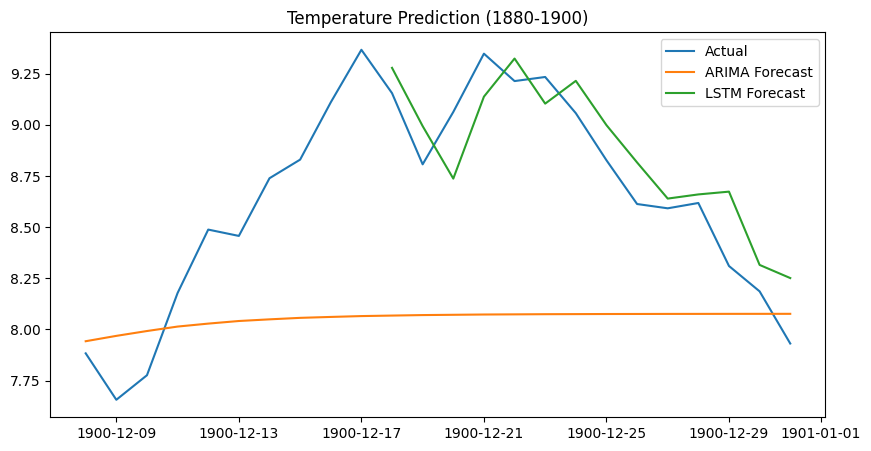

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
Period 1900-1920
ARIMA: MAE=0.2620, RMSE=0.3160
LSTM: MAE=0.1307, RMSE=0.1480



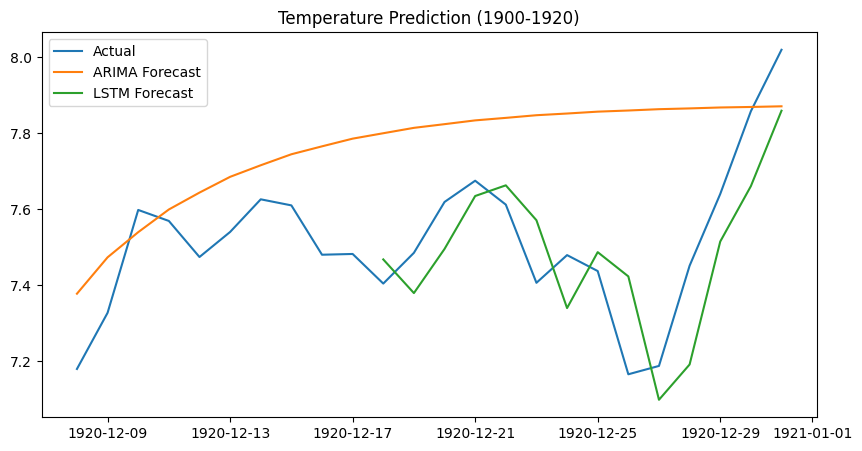

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
Period 1920-1940
ARIMA: MAE=0.3668, RMSE=0.4295
LSTM: MAE=0.1338, RMSE=0.1631



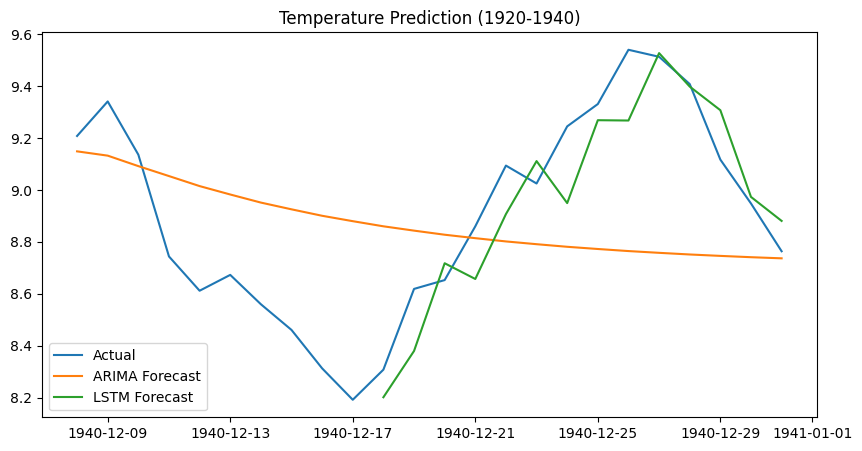

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
Period 1940-1960
ARIMA: MAE=0.2552, RMSE=0.2978
LSTM: MAE=0.1250, RMSE=0.1809



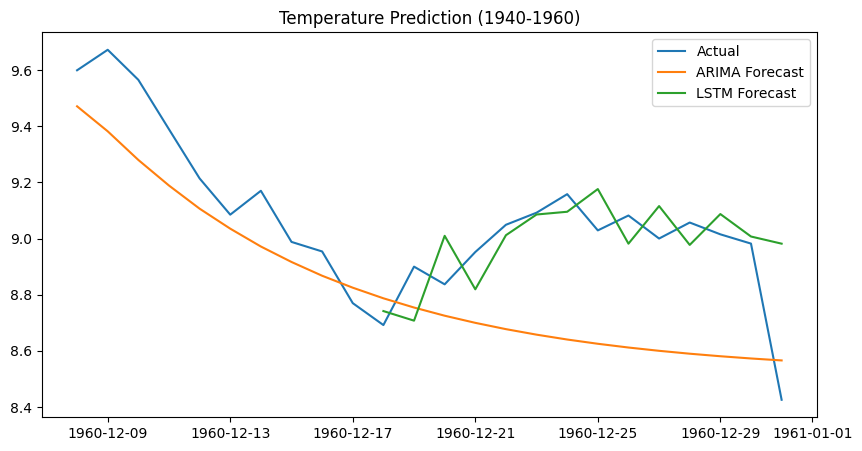

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
Period 1960-1980
ARIMA: MAE=0.3459, RMSE=0.4464
LSTM: MAE=0.1366, RMSE=0.1577



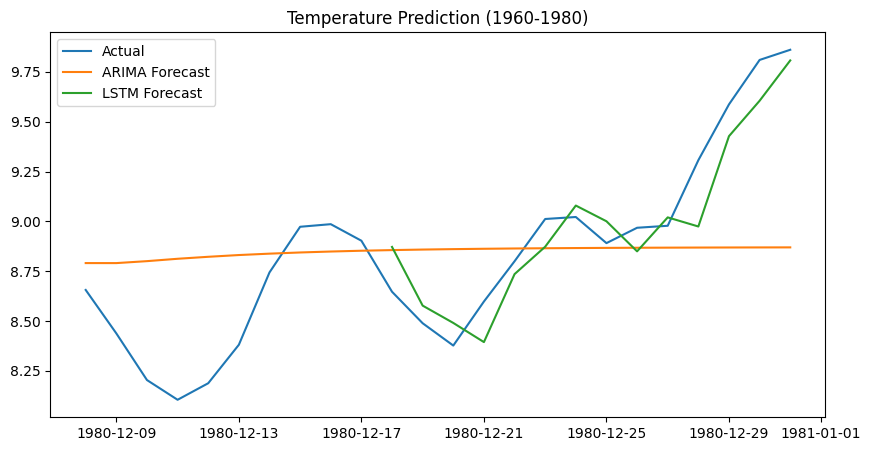

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
Period 1980-2000
ARIMA: MAE=0.2316, RMSE=0.2600
LSTM: MAE=0.0921, RMSE=0.1096



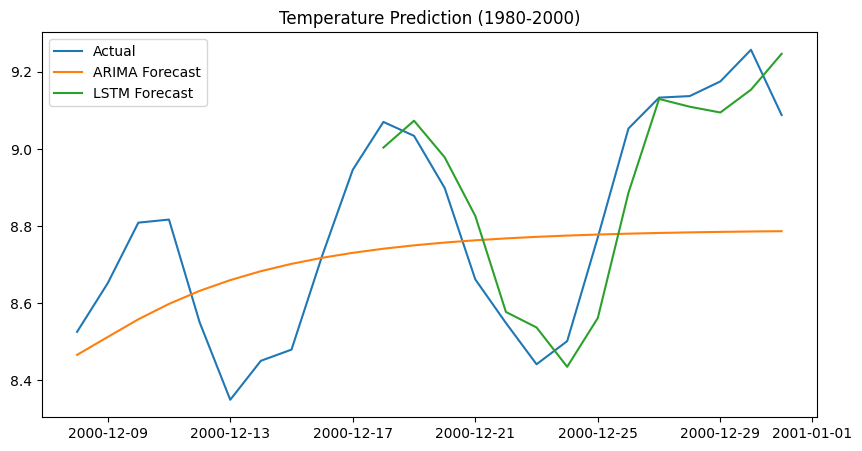

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
Period 2000-2020
ARIMA: MAE=0.6488, RMSE=0.6856
LSTM: MAE=0.1111, RMSE=0.1406



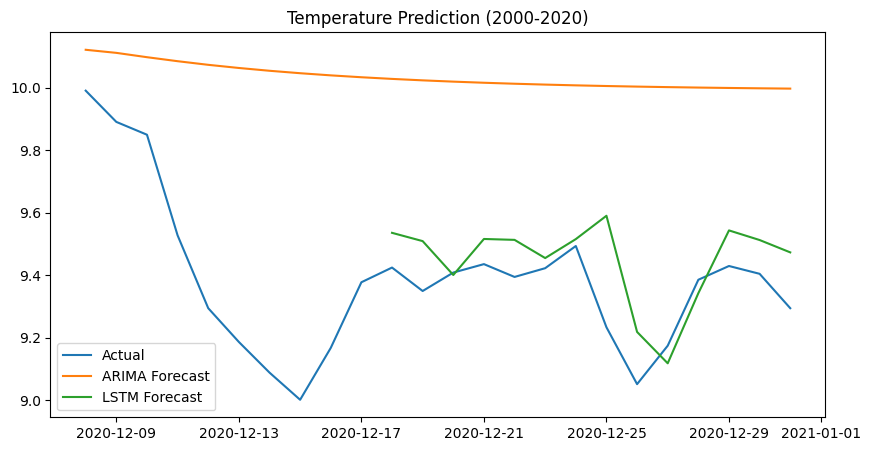

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import shapiro, normaltest, anderson
import warnings
warnings.filterwarnings("ignore")


# Check normality
plt.figure(figsize=(12, 6))
sns.histplot(df['Temperature'].dropna(), bins=50, kde=True)
plt.title('Temperature Distribution')
plt.show()

# Shapiro-Wilk Test
shapiro_test = shapiro(df['Temperature'].dropna()[:5000])  # Limit sample size due to test constraint
print(f'Shapiro-Wilk Test: Statistic={shapiro_test.statistic:.4f}, p-value={shapiro_test.pvalue:.4f}')

# D’Agostino and Pearson’s Test
dagostino_test = normaltest(df['Temperature'].dropna())
print(f'D’Agostino and Pearson Test: Statistic={dagostino_test.statistic:.4f}, p-value={dagostino_test.pvalue:.4f}')

# Anderson-Darling Test
anderson_test = anderson(df['Temperature'].dropna())
print('Anderson-Darling Test:')
for i in range(len(anderson_test.critical_values)):
    print(f'  {anderson_test.significance_level[i]}%: {anderson_test.critical_values[i]:.4f}')

# Plot time series
plt.figure(figsize=(12,6))
plt.plot(df, label='Global Temperature')
plt.title('Global Temperature Anomaly (1880-2020)')
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.legend()
plt.show()

# Function to evaluate models
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mae, rmse

# Function to fit ARIMA model
def fit_arima(train, test):
    model = ARIMA(train, order=(3,1,3))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(test))
    return forecast

# Function to fit LSTM model
def fit_lstm(train, test):
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train.values.reshape(-1,1))
    
    X_train, y_train = [], []
    for i in range(10, len(train_scaled)):
        X_train.append(train_scaled[i-10:i, 0])
        y_train.append(train_scaled[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(loss='mse', optimizer='adam')
    model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=0)
    
    test_scaled = scaler.transform(test.values.reshape(-1,1))
    X_test = np.array([test_scaled[i-10:i, 0] for i in range(10, len(test_scaled))])
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred_scaled)
    return y_pred

# Time-Split Modeling
for start in range(1880, 2001, 20):
    end = start + 20
    subset = df.loc[f'{start}':f'{end}']
    train, test = subset.iloc[:-24], subset.iloc[-24:]
    
    # ARIMA Model
    arima_forecast = fit_arima(train, test)
    
    # LSTM Model
    lstm_forecast = fit_lstm(train, test)
    
    # Evaluate Models
    arima_mae, arima_rmse = evaluate_model(test, arima_forecast)
    lstm_mae, lstm_rmse = evaluate_model(test[-len(lstm_forecast):], lstm_forecast)
    
    print(f'Period {start}-{end}')
    print(f'ARIMA: MAE={arima_mae:.4f}, RMSE={arima_rmse:.4f}')
    print(f'LSTM: MAE={lstm_mae:.4f}, RMSE={lstm_rmse:.4f}\n')
    
    # Plot Results
    plt.figure(figsize=(10, 5))
    plt.plot(test.index, test, label='Actual')
    plt.plot(test.index, arima_forecast, label='ARIMA Forecast')
    plt.plot(test.index[-len(lstm_forecast):], lstm_forecast, label='LSTM Forecast')
    plt.title(f'Temperature Prediction ({start}-{end})')
    plt.legend()
    plt.show()


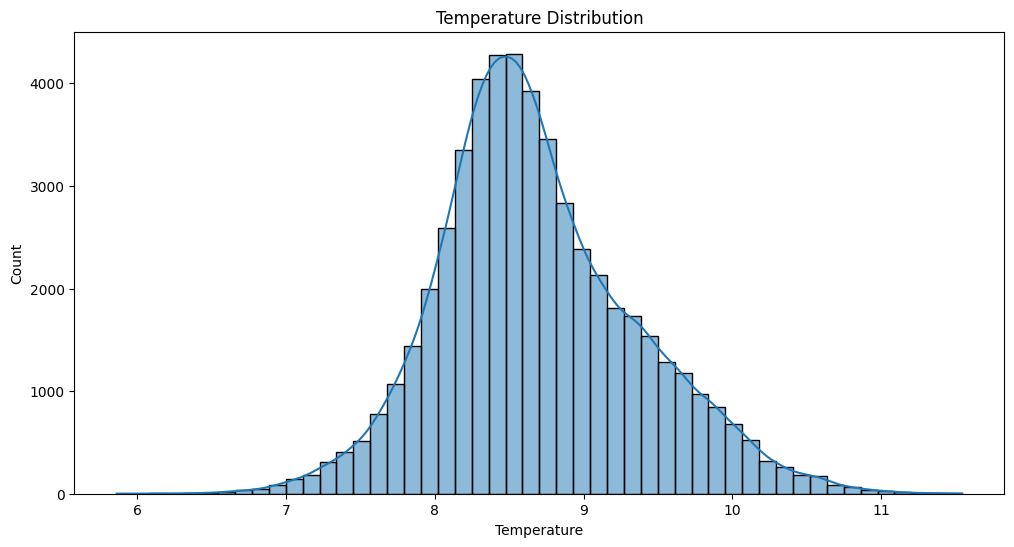

Shapiro-Wilk Test: Statistic=0.9765, p-value=0.0000
D’Agostino and Pearson Test: Statistic=1555.4371, p-value=0.0000
Anderson-Darling Test:
  15.0%: 0.5760
  10.0%: 0.6560
  5.0%: 0.7870
  2.5%: 0.9180
  1.0%: 1.0920


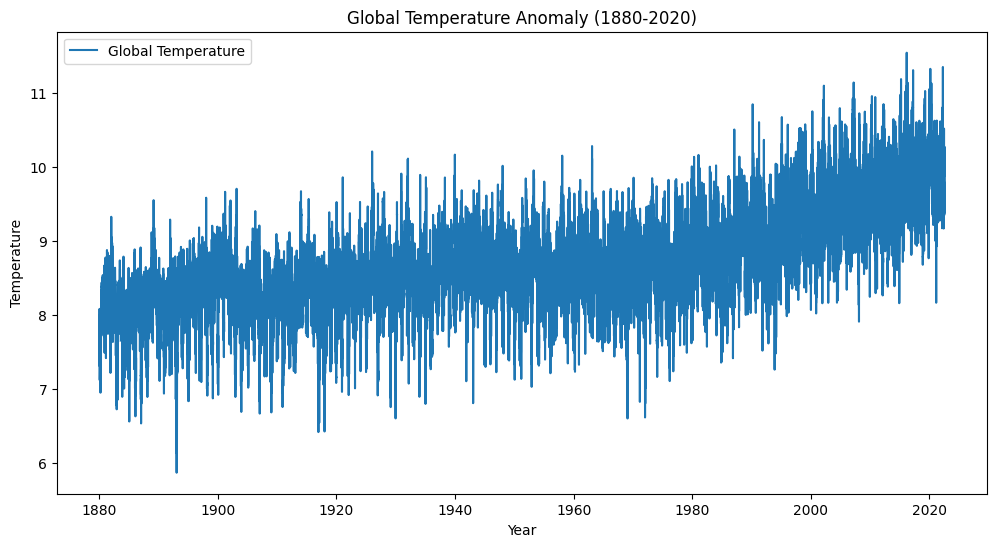

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
Month: 1
ARIMA: MAE=0.2484, RMSE=0.3090
LSTM: MAE=0.0826, RMSE=0.0959



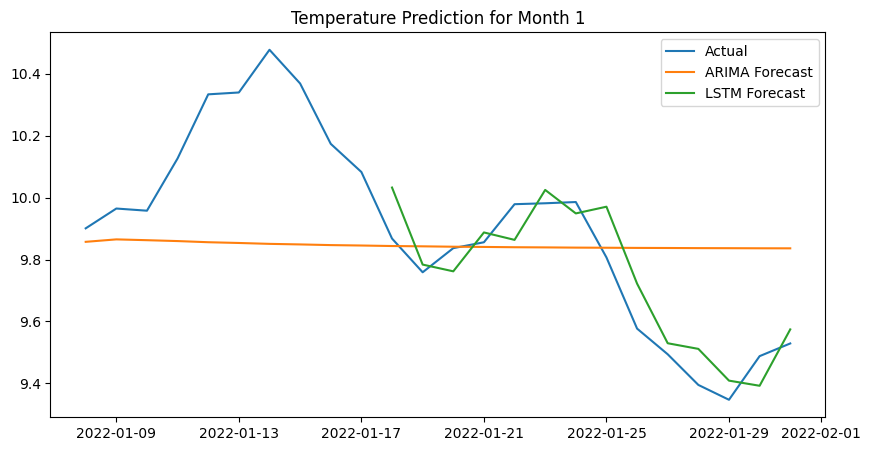

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
Month: 2
ARIMA: MAE=0.3649, RMSE=0.4546
LSTM: MAE=0.1419, RMSE=0.1672



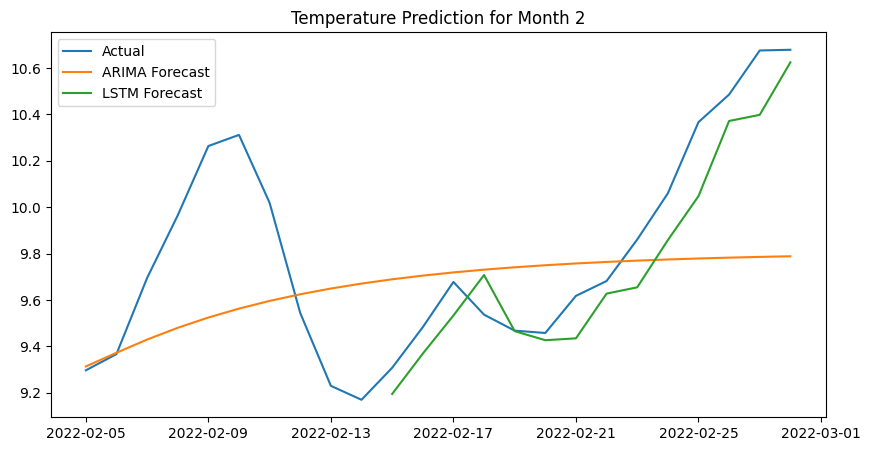

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
Month: 3
ARIMA: MAE=0.3542, RMSE=0.4162
LSTM: MAE=0.1582, RMSE=0.1861



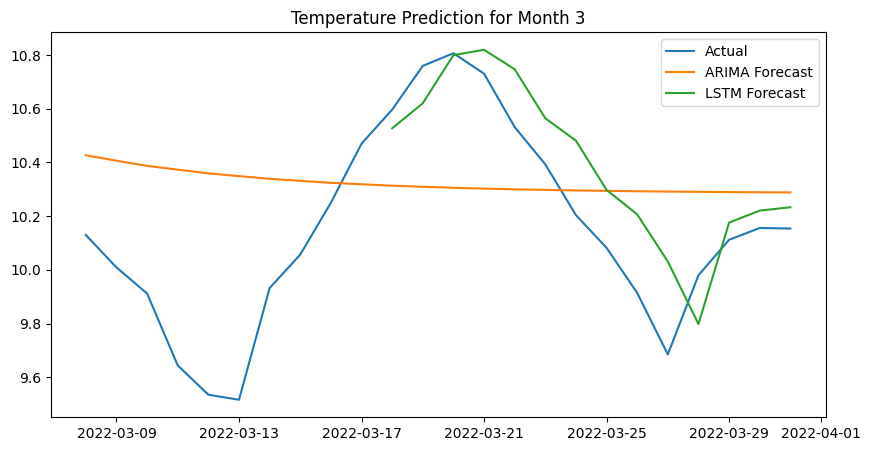

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
Month: 4
ARIMA: MAE=0.4593, RMSE=0.5077
LSTM: MAE=0.0874, RMSE=0.1082



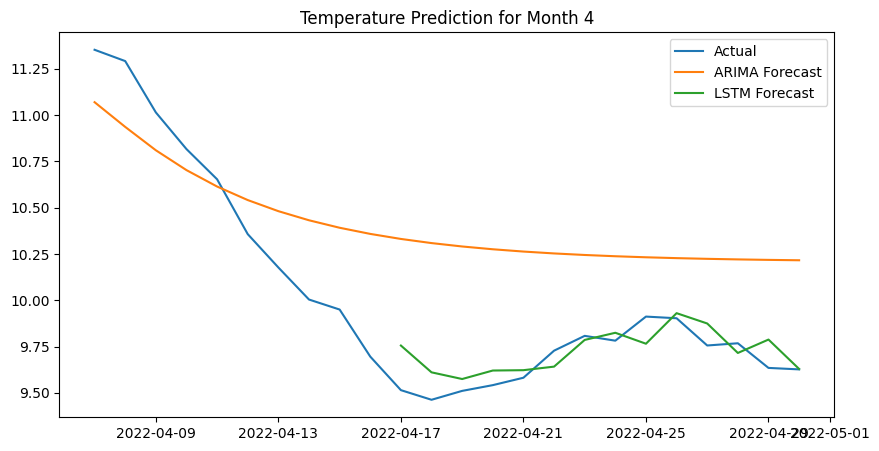

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step
Month: 5
ARIMA: MAE=0.2416, RMSE=0.2966
LSTM: MAE=0.1751, RMSE=0.2281



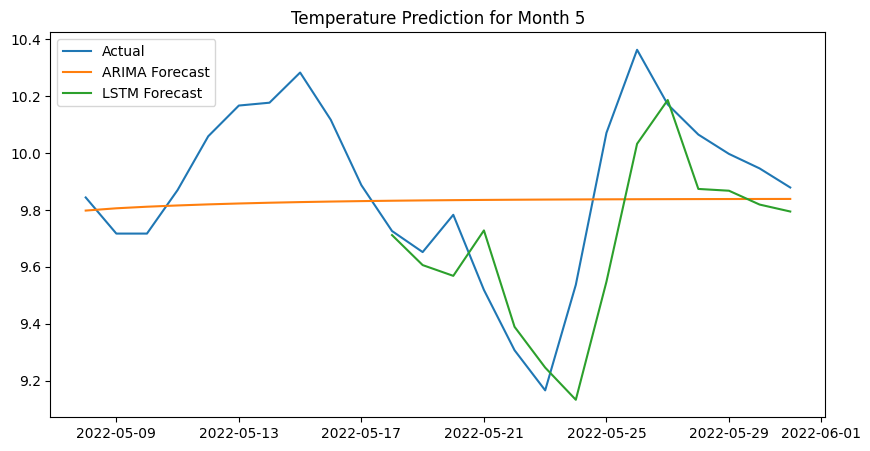

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
Month: 6
ARIMA: MAE=0.3134, RMSE=0.3510
LSTM: MAE=0.1118, RMSE=0.1293



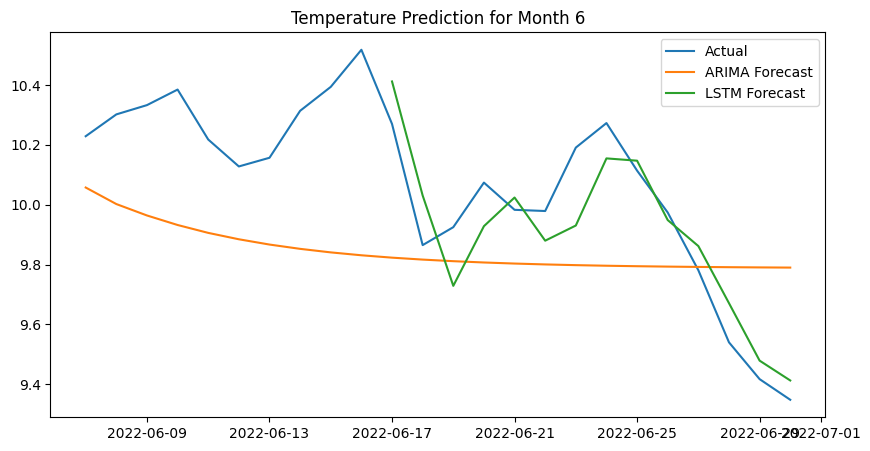

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
Month: 7
ARIMA: MAE=0.2547, RMSE=0.3069
LSTM: MAE=0.1334, RMSE=0.1598



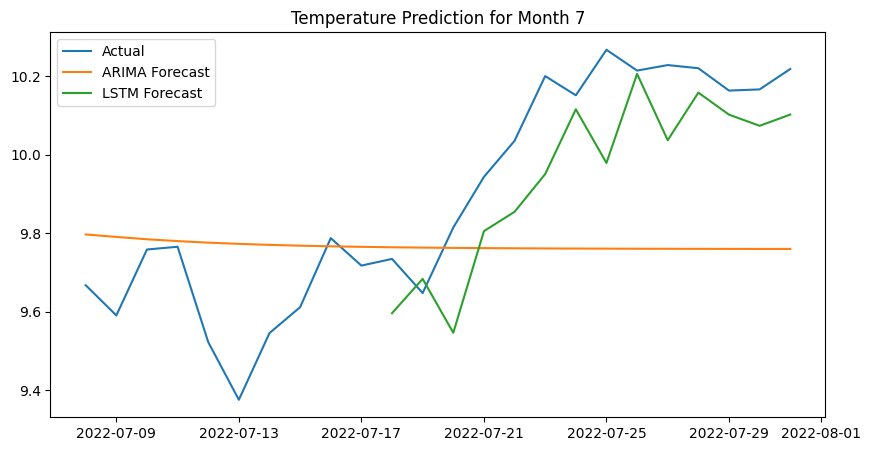

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Month: 8
ARIMA: MAE=0.2118, RMSE=0.2482
LSTM: MAE=0.1003, RMSE=0.1331



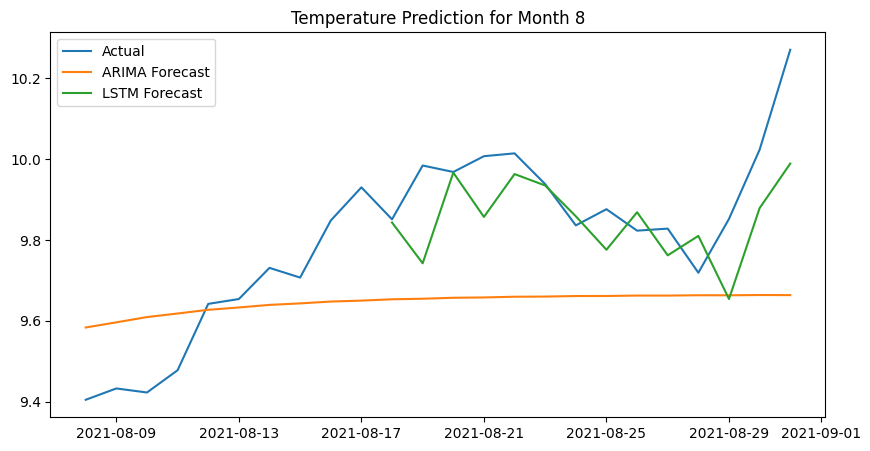

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
Month: 9
ARIMA: MAE=0.1646, RMSE=0.2224
LSTM: MAE=0.1142, RMSE=0.1303



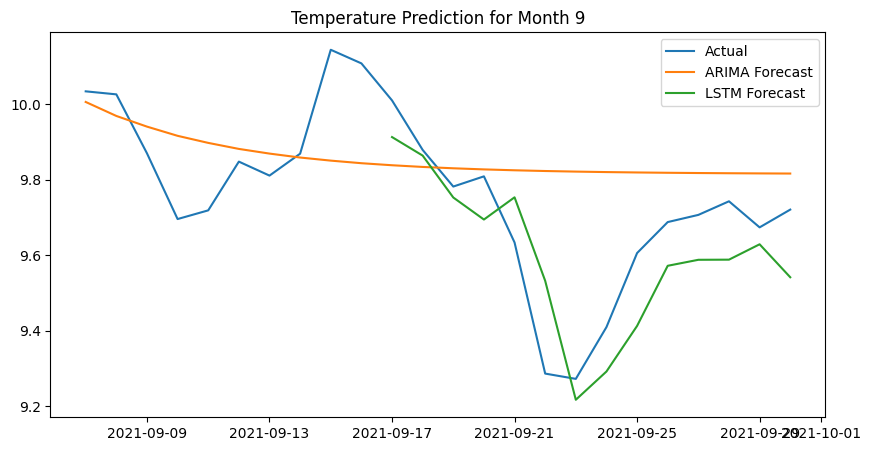

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
Month: 10
ARIMA: MAE=0.3159, RMSE=0.3690
LSTM: MAE=0.1254, RMSE=0.1610



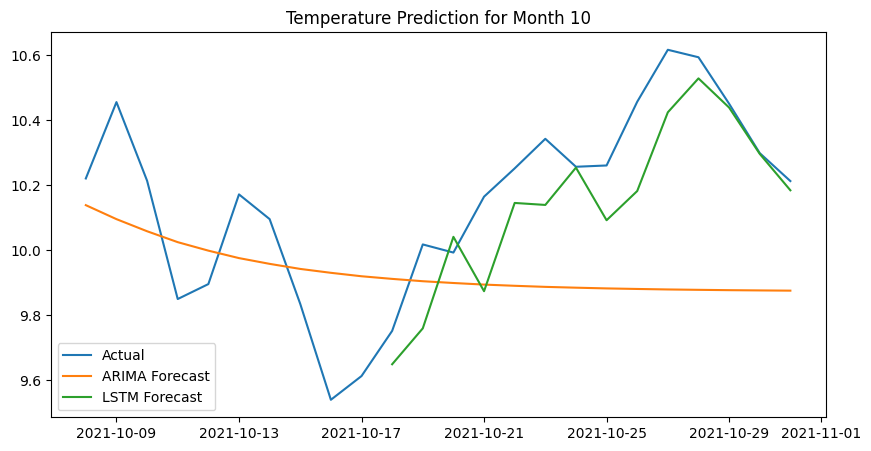

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
Month: 11
ARIMA: MAE=0.1665, RMSE=0.2026
LSTM: MAE=0.0738, RMSE=0.0975



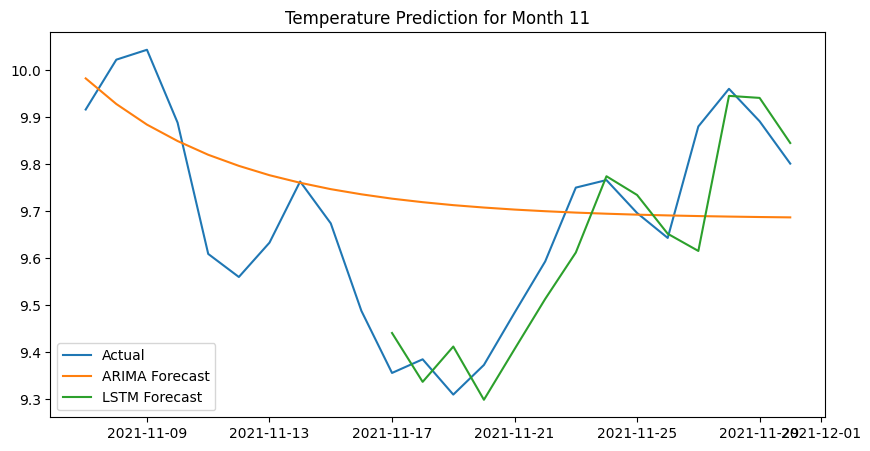

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
Month: 12
ARIMA: MAE=0.1840, RMSE=0.2432
LSTM: MAE=0.0682, RMSE=0.1022



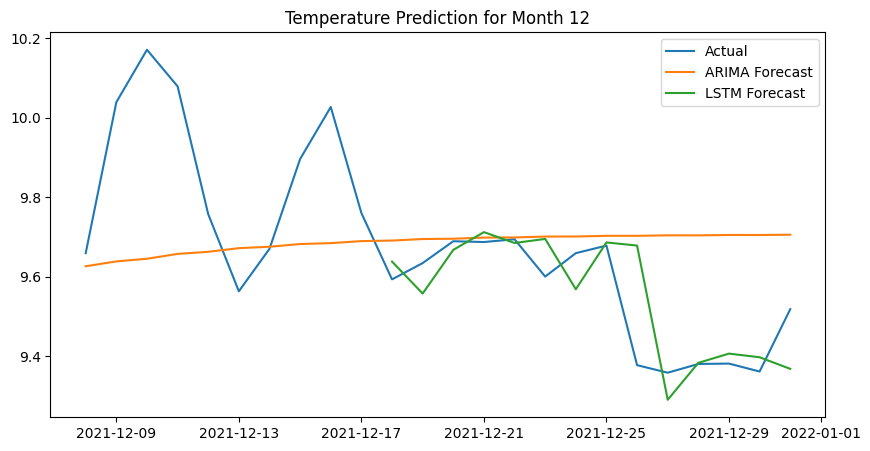

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import shapiro, normaltest, anderson
import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv(r"C:\Users\marat\OneDrive\Desktop\project\global temperature.csv")
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
df.set_index('Date', inplace=True)
df = df[['Temperature']]

# Check normality
plt.figure(figsize=(12, 6))
sns.histplot(df['Temperature'].dropna(), bins=50, kde=True)
plt.title('Temperature Distribution')
plt.show()

# Shapiro-Wilk Test
shapiro_test = shapiro(df['Temperature'].dropna()[:5000])  # Limit sample size due to test constraint
print(f'Shapiro-Wilk Test: Statistic={shapiro_test.statistic:.4f}, p-value={shapiro_test.pvalue:.4f}')

# D’Agostino and Pearson’s Test
dagostino_test = normaltest(df['Temperature'].dropna())
print(f'D’Agostino and Pearson Test: Statistic={dagostino_test.statistic:.4f}, p-value={dagostino_test.pvalue:.4f}')

# Anderson-Darling Test
anderson_test = anderson(df['Temperature'].dropna())
print('Anderson-Darling Test:')
for i in range(len(anderson_test.critical_values)):
    print(f'  {anderson_test.significance_level[i]}%: {anderson_test.critical_values[i]:.4f}')

# Plot time series
plt.figure(figsize=(12,6))
plt.plot(df, label='Global Temperature')
plt.title('Global Temperature Anomaly (1880-2020)')
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.legend()
plt.show()

# Function to evaluate models
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mae, rmse

# Function to fit ARIMA model
def fit_arima(train, test):
    model = ARIMA(train, order=(3,1,3))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(test))
    return forecast

# Function to fit LSTM model
def fit_lstm(train, test):
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train.values.reshape(-1,1))
    
    X_train, y_train = [], []
    for i in range(10, len(train_scaled)):
        X_train.append(train_scaled[i-10:i, 0])
        y_train.append(train_scaled[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(loss='mse', optimizer='adam')
    model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=0)
    
    test_scaled = scaler.transform(test.values.reshape(-1,1))
    X_test = np.array([test_scaled[i-10:i, 0] for i in range(10, len(test_scaled))])
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred_scaled)
    return y_pred

# Fit models for each month separately
for month in range(1, 13):
    df_monthly = df[df.index.month == month]
    train, test = df_monthly.iloc[:-24], df_monthly.iloc[-24:]
    
    # ARIMA Model
    arima_forecast = fit_arima(train, test)
    
    # LSTM Model
    lstm_forecast = fit_lstm(train, test)
    
    # Evaluate Models
    arima_mae, arima_rmse = evaluate_model(test, arima_forecast)
    lstm_mae, lstm_rmse = evaluate_model(test[-len(lstm_forecast):], lstm_forecast)
    
    print(f'Month: {month}')
    print(f'ARIMA: MAE={arima_mae:.4f}, RMSE={arima_rmse:.4f}')
    print(f'LSTM: MAE={lstm_mae:.4f}, RMSE={lstm_rmse:.4f}\n')
    
    # Plot Results
    plt.figure(figsize=(10, 5))
    plt.plot(test.index, test, label='Actual')
    plt.plot(test.index, arima_forecast, label='ARIMA Forecast')
    plt.plot(test.index[-len(lstm_forecast):], lstm_forecast, label='LSTM Forecast')
    plt.title(f'Temperature Prediction for Month {month}')
    plt.legend()
    plt.show()


"Command 'jupyter nbconvert --to pdf C:/Users/marat/OneDrive/Desktop/project/.ipynb_checkpoints/gtcp-checkpoint.ipynb --output C:/Users/marat/OneDrive/Desktop/project.pdf' returned non-zero exit status 1."